### Finding patient details (update for every new patient!)

In [1]:
import os, re, glob

def findDetails(path):
    name = path.split(r'/')[-1]
    pattern = r'^([^\s_]+)_P(\d+)_M(\d+).bspm$'
    # Search for the pattern in the given filename
    match = re.search(pattern,name)
    if match:
        region = match.group(1)  # The entire V value (e.g., V1, V2-V3)
        patient = match.group(2)  # The number following 'P'
        measurement = match.group(3)  # The number following 'M'
    else:
        raise ValueError("Filename \"{}\" does not match the expected pattern.".format(name))
    
    healthy_list = str([17])
    B1_list = str([19, 20, 21, 24, 26, 27, 29])
    B2_list = str([18, 22, 23, 25, 28])
    if patient in healthy_list:
        stage = 'HEALTHY'
    elif patient in B1_list:
        stage = 'B1'
    elif patient in B2_list:
        stage = 'B2'
    else:
        raise ValueError(f"Patient {patient} needs to be assigned a stage - put patient number in appropriate list.")
    print('pateint', patient)
    print('stage', stage)
    return region, measurement, stage, patient

### Function to find 3 peaks of the QRS

In [2]:
import wfdb.processing
import numpy as np
import pandas as pd
import os, re, glob
import matplotlib.pyplot as plt
from biolab.bspm import BSPM
from biolab.utils import apply2all
import plotly.express as px
import plotly.graph_objects as go
from scipy.signal import find_peaks
import scipy.signal as signal

def find_3_peaks(signal_segment, center_index, search_window):

    start = max(0, center_index - search_window)
    end = min(len(signal_segment), center_index + search_window)

    search_area = signal_segment[start:end]
    #peaks, _ = find_peaks(search_area)
    pos_peaks, _ = signal.find_peaks(search_area)  # find the index of the peak 
    neg_peaks, _ = signal.find_peaks(-search_area)  # Flip the signal to find negative peaks

    # Combine both types of peaks
    all_peaks = np.concatenate([pos_peaks, neg_peaks])
    all_peaks = sorted(all_peaks) 
    #print(all_peaks)

    three_peaks = []
    if len(all_peaks) < 3:
        print('less than 3 peaks found') # Fallback if no peaks are found
        return None #np.array([center_index]*3) #DONT RETURN ANYTHING...... CAN'T BE A VALID CYCLE IF U DON'T FIND ANY PEAKS AROUND IT
    else:
        tallest_peak_idx = all_peaks[np.argmax(np.abs(search_area[all_peaks]))]
        r_peak_index = start + tallest_peak_idx
        #print('first r_peak_index', r_peak_index)
        three_peaks.append(r_peak_index)
        all_peaks.remove(tallest_peak_idx)


        while len(three_peaks) < 3  and len(all_peaks) != 0:
            #print('all_peaks', all_peaks)
            tallest_peak_idx = all_peaks[np.argmax(np.abs(search_area[all_peaks]))]
            # some detect peaks are too close to each other so i only consider the ones outside ±15 as a different peak
            if np.min(np.abs(start + tallest_peak_idx - np.array(three_peaks))) > 15:
                r_peak_index = start + tallest_peak_idx
                #print('first r_peak_index', r_peak_index)
                three_peaks.append(r_peak_index)
            else:
                pass
                #print('detected peak is too close to previous detected peak')

            all_peaks.remove(tallest_peak_idx)

        if len(three_peaks) < 3:
            return None

        return np.sort(three_peaks)

### Spider plot interactive

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import os, glob, re


def plotSpiderplot(readpath):
    #Import SNR data from Excel
    df = pd.read_excel(io=readpath)
    #print(df)
    # Set 'Position' as the index
    df = df.drop('patient', axis = 1).drop('search_window', axis=1)#.drop('timestamp', axis=1)
    df.set_index('stage',inplace=True)
    # Group by 'Position' and calculate mean and std for each channel
    grouped = df.groupby('stage').agg(['median','std'])  # mean vs median
    # Channels as columns (without multi-indexing)
    channels = df.columns
    num_channels = len(channels)
    # Prepare the angle array for the radar chart (evenly distributed for each channel)
    angles = np.linspace(0,2*np.pi,num_channels,endpoint=False).tolist()
    # Close the loop by repeating the first angle
    angles += angles[:1]
    # Create a figure for the radar chart
    fig, ax = plt.subplots(figsize=(6,6),subplot_kw=dict(polar=True))
    # Loop through each position and plot the radar chart
    color = {'B1':'blue','B2':'red','HEALTHY':'green'}  # ,
    for position in grouped.index:
        # Calculate the mean and standard deviation for each channel
        mean_delays = grouped.loc[position,(channels,'median')].values
        std_delays = grouped.loc[position,(channels,'std')].values
        # Close the loop by appending the first value of the mean and std
        mean_delays = np.append(mean_delays,mean_delays[0])
        std_delays = np.append(std_delays,std_delays[0])
        # Plot the shaded standard deviation area
        #ax.fill(angles,mean_delays+std_delays,color=color[position],alpha=0.2)  # Shaded area
        #ax.fill(angles, mean_delays - std_delays, color=color[position], alpha=0.2)  # Shaded area
        # Plot the mean delay
        ax.plot(angles, mean_delays, label=f'Position {position}', linewidth=2, marker='o')
    # Remove radial ticks
    ax.set_yticklabels([])
    # Set axis labels for the channels
    ax.set_xticks(angles[:-1])  # Set the angles for the channels
    ax.set_xticklabels(channels)
    # Set the title of the radar chart
    ax.set_title("Radar Chart: Median Delay (V1)", size=16, color='black', y=1.1)
    # Add a legend
    ax.legend(title="Positions", loc='upper right')
    # Show the chart
    plt.show()


def plotSpiderplotInteractive(readpath, patientnum):


    df = pd.read_excel(io=readpath)

    df_patient = df.query(f"patient == {patientnum}")

    index_column = df_patient['stage']
    #print('index_column', index_column)
    value_columns = df_patient.drop('stage',axis=1).drop('patient',axis=1).drop('search_window', axis =1).drop('timestamp', axis=1) #= [("Delay_ch"+str(ch)) for ch in rMP.preprocessed_data.columns[1:]]
    #print('value_columns', value_columns)

    df_filtered = pd.concat([index_column, value_columns], axis = 1)
    #print('df_filtered', df_filtered)
    
    chs = value_columns.columns
    #print('chs!!!', chs)

    fig = go.Figure()

    #color_scale = px.colors.qualitative.Set1  # Choose a color scheme
    #category_colors = {cat: color_scale[i % len(color_scale)] for i, cat in enumerate(df["stage"])}

    for index, row in df_filtered.iterrows():
        #print('index!!!', index)

        #print('row!!!', row)

        fig.add_trace(go.Scatterpolar(
            r=row[chs].values,  # Metric values
            theta=chs,          # Metric labels
            mode="lines",        # Line plot
            name=row["stage"]#,    patient # Row label
            #line=dict(color=category_colors[row["stage"]])
            ))

    fig.update_layout(
    title=patientnum,
    polar=dict(radialaxis=dict(visible=True)), #, range=[-21, 21]
    showlegend=True
    )
    
    fig.show()


In [15]:
#patientnum = 18
#readpath = r'/Users/arzina/Library/CloudStorage/OneDrive-UniversityofCambridge/11B/4TH YR PROJECT/threePC_Delays.xlsx'
#readpath = r'/Users/arzina/Library/CloudStorage/OneDrive-UniversityofCambridge/11B/4TH YR PROJECT/Delays_thirdof3peaks/P28.xlsx'#ManualDelays/test_manualDelays_P22.xlsx'##ManualDelays/SpiderPlotData.xlsx'
#addons = ['all_fs2000AMPS.xlsx','all_fs2000GRADANGLE.xlsx','all_fs2000GRADMAG.xlsx','all_fs2000ORIGINAL.xlsx']
#addons = ['all_fs2000AMPS_SCALEDPERPATIENT.xlsx','all_fs2000ORIGINAL_SCALEDPERPATIENT.xlsx']#'all_fs2000AMPS.xlsx'#'all_fs2000AMPS.xlsx'#'all_fs2000AMPS_SCALEDPERPATIENT.xlsx'#'all_fs2000_SCALEDPERPATIENT.xlsx'#'all_fs2000AMPS.xlsx'#'all_fs2000ORIGINAL.xlsx'
#for addon in addons:
#readpath = r'/Users/arzina/Library/CloudStorage/OneDrive-UniversityofCambridge/11B/4TH YR PROJECT/Delays_thirdof3peaks/Delays_SearchWdw100/all_fs2000WIDTHS.xlsx'# + addon
#readpath = r'/Users/arzina/Library/CloudStorage/OneDrive-UniversityofCambridge/11B/4TH YR PROJECT/Delays_thirdof3peaks/Delays_SearchWdw100/all_fs2000SW400.xlsx'
#readpath = r'/Users/arzina/Library/CloudStorage/OneDrive-UniversityofCambridge/11B/4TH YR PROJECT/FeatureMatrices/V1/amps/amps_WITHANOMALIES.xlsx'
#readpath = r'/Users/arzina/Desktop/HFD.xlsx'
readpath = r'/Users/arzina/Library/CloudStorage/OneDrive-UniversityofCambridge/11B/4TH YR PROJECT/FeatureMatrices/fhigh20/V1/hfd/hfd_STANDARDISED.xlsx'
patients = [23]#18,19,21,22,23,24,25,26,27,28,29] #18,19,)
for patientnum in patients:
    plotSpiderplotInteractive(readpath, patientnum)

#plotSpiderplot(readpath)

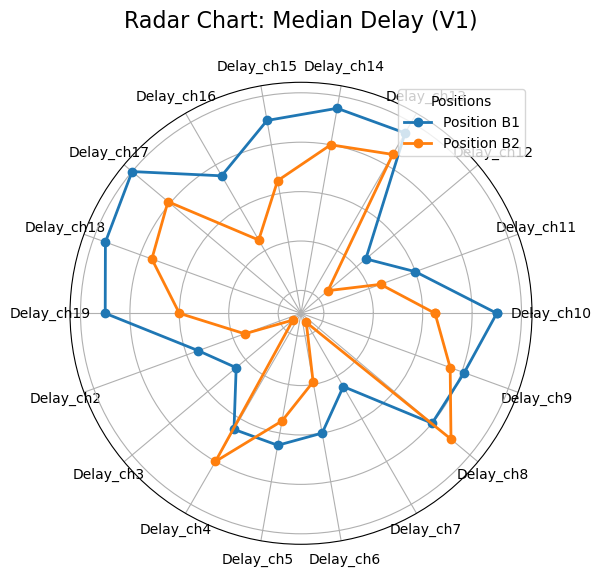

In [98]:
readpath = r'/Users/arzina/Library/CloudStorage/OneDrive-UniversityofCambridge/11B/4TH YR PROJECT/FeatureMatrices/fhigh20/V2-V3/delays/delays_SCALEDPERPATIENT.xlsx'
plotSpiderplot(readpath)

### Boxplot and pairplot

In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

#filepath =  r'/Users/arzina/Library/CloudStorage/OneDrive-UniversityofCambridge/11B/4TH YR PROJECT/Delays_thirdof3peaks/all_fs2000GRADMAG.xlsx'
filepath = r'/Users/arzina/Library/CloudStorage/OneDrive-UniversityofCambridge/11B/4TH YR PROJECT/Delays_thirdof3peaks/Delays_SearchWdw100/all_fs2000WIDTHS10.xlsx'

data = pd.read_excel(filepath)
#print(data)
sns.boxplot(x='stage', y='ratio_rise_fwhm10', data=data)
plt.show()

#print(data[['Grad_magn_ch10', 'stage']].head(80))
sns.pairplot(data, hue='stage', vars=['ratio_rise_fwhm10'])

FileNotFoundError: [Errno 2] No such file or directory: '/Users/arzina/Library/CloudStorage/OneDrive-UniversityofCambridge/11B/4TH YR PROJECT/higuchiFD/hfd.xlsx'

### Violin plot

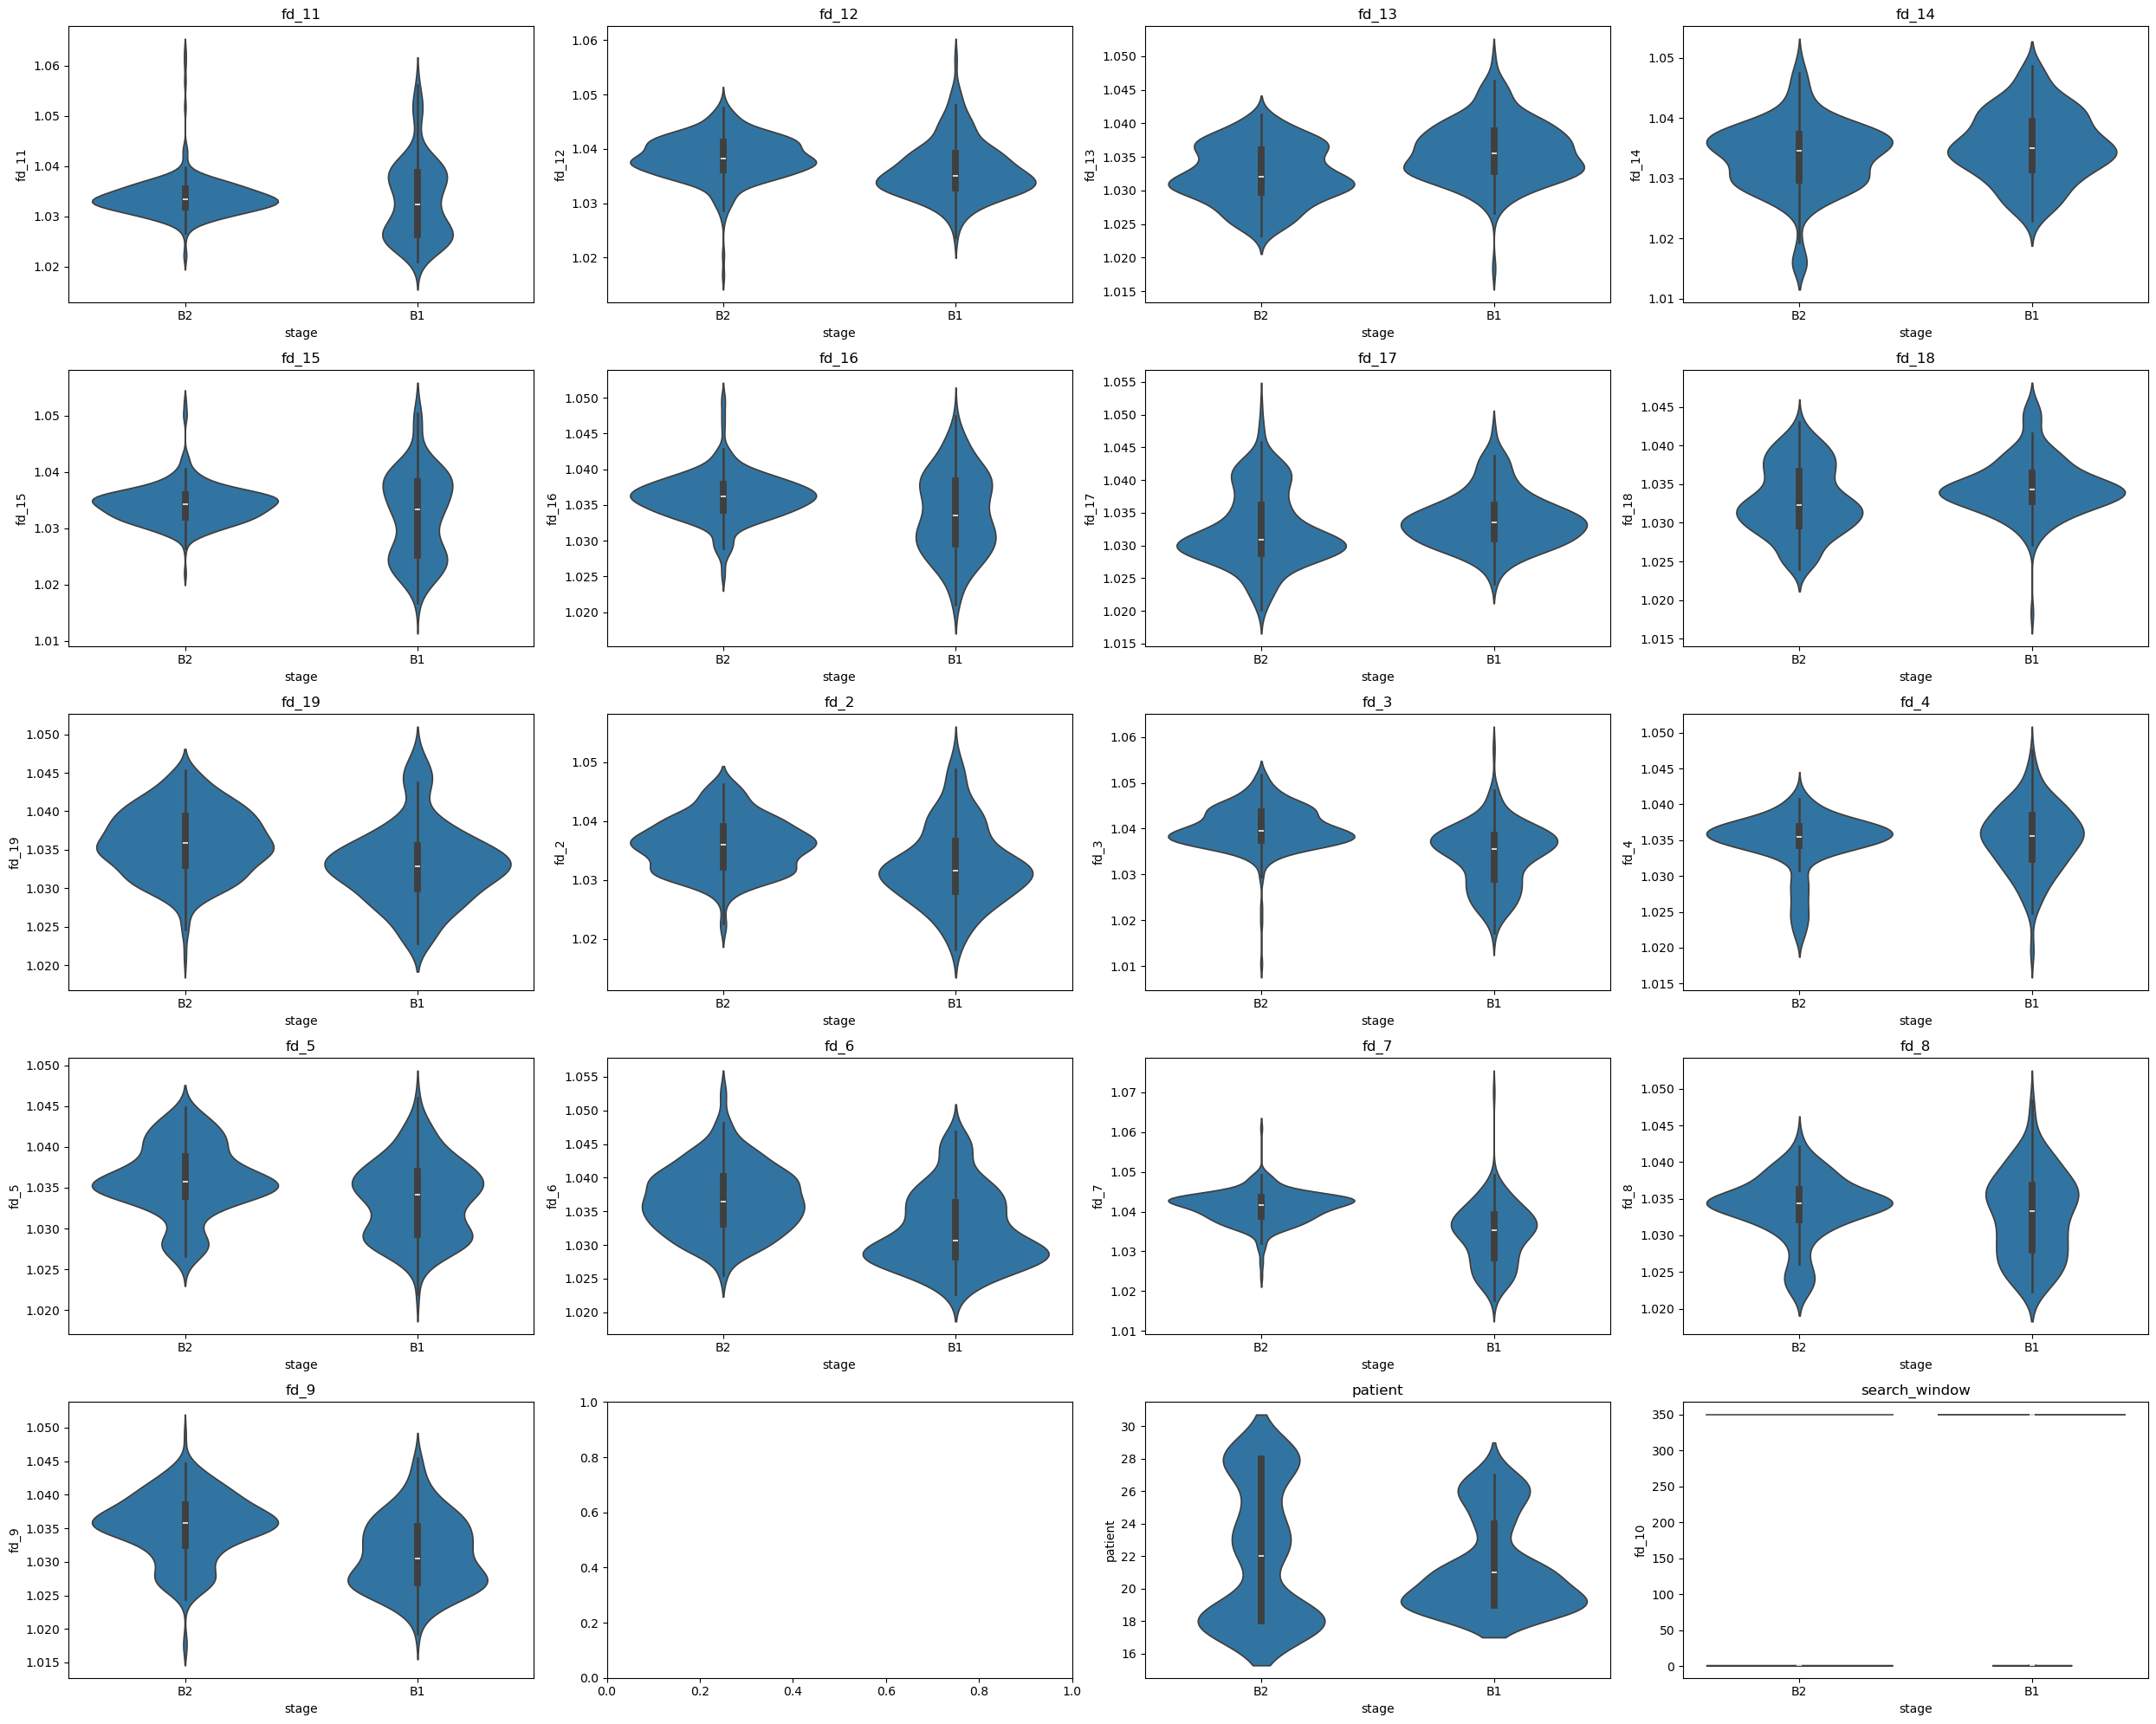

In [42]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

#readpath = r'/Users/arzina/Library/CloudStorage/OneDrive-UniversityofCambridge/11B/4TH YR PROJECT/Delays_thirdof3peaks/all_fs2000AMPS.xlsx'
readpath = r'/Users/arzina/Library/CloudStorage/OneDrive-UniversityofCambridge/11B/4TH YR PROJECT/Delays_thirdof3peaks/Delays_SearchWdw100/all_fs2000WIDTHS10.xlsx'
readpath = r'/Users/arzina/Library/CloudStorage/OneDrive-UniversityofCambridge/11B/4TH YR PROJECT/FeatureMatrices/V1/hfd/hfd.xlsx'
df = pd.read_excel(io=readpath)
df.drop('patient', axis=1).drop('stage', axis = 1).drop('search_window', axis = 1)

# Set up a grid of 5 rows x 4 columns
fig, axes = plt.subplots(5, 4, figsize=(25, 20))  # Adjust size for readability

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Loop through columns and plot each in its own subplot
for i, col in enumerate(df.columns):
    if col == 'stage':
        continue  # Skip the 'stage' column itself if it's one of the columns
    ax = axes[i-1]  # Use the flattened axes array
    sns.violinplot(x='stage', y=col, data=df, order=df['stage'].unique(), ax=ax)
    ax.set_title(col)

# Adjust layout so plots don't overlap
plt.tight_layout()
plt.savefig('amps.png')
plt.show()



In [ ]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

readpath = r'/Users/arzina/Library/CloudStorage/OneDrive-UniversityofCambridge/11B/4TH YR PROJECT/Delays_thirdof3peaks/all_fs2000.xlsx'
""" df = pd.read_excel(io=readpath)
fig, axes = plt.subplots(5, 4, figsize=(4, 3))
for col in df.columns:
    #print(df.columns)
    #fig, axes = plt.subplots(5, 4, figsize=(4, 3))
    sns.violinplot(x='stage',y=col,data=df,order=df['stage'].unique()) """

df = pd.read_excel(io=readpath)


sns.violinplot(x='stage', y='Delay_ch10', data=df)#, order=df['stage'].unique(), ax=ax)
    #ax.set_title(col)

# Adjust layout so plots don't overlap
#plt.tight_layout()
plt.show()


### Logistic Regression & Data Scaling

#### Function for calculating and saving accuracy and consistency

In [5]:
import os
import pandas as pd

def AccAndConsistency(cm, clfClasses, acc_cons_path, patientnum):

    class_metrics = []
    for i, class_name in enumerate(clfClasses):
        row = cm[i]
        support = np.sum(row)
        correct = row[i]
        most_common_pred = np.max(row)
        
        if support > 0:
            accuracy = correct / support
            consistency = most_common_pred / support
            
            class_metrics.append({
                "Class": class_name,
                "Accuracy": round(accuracy, 3),
                "Consistency": round(consistency, 3),
                "Support": support,
                "Patient tested on": patientnum})

    # Display results as a DataFrame
    df = pd.DataFrame(class_metrics)
    print(df)

    if os.path.exists(acc_cons_path):
        existing_df = pd.read_excel(acc_cons_path)
        combined_df = pd.concat([existing_df, df], ignore_index=True)#.drop_duplicates()
        combined_df.to_excel(acc_cons_path, index=False)
        print("Data merged and saved to Excel file.")
    else:
        df.to_excel(acc_cons_path, index=False)
        print("Excel file created with new data.")

#### Test data is a mixture of all data 

Repeated Cross-Validation Accuracy: 0.95 ± 0.04
Intercept: [1.65484001]
Coefficients: [[-0.64400656  0.26917407  0.3411049  -1.14754037  0.50592114 -1.26037439
   0.38826908  0.08550363 -0.2174307  -0.82571463 -0.61455175 -2.80612113
   2.4327551  -0.55187129 -0.75885964  0.32523765  0.2495501   0.92073464
   2.38023231]]


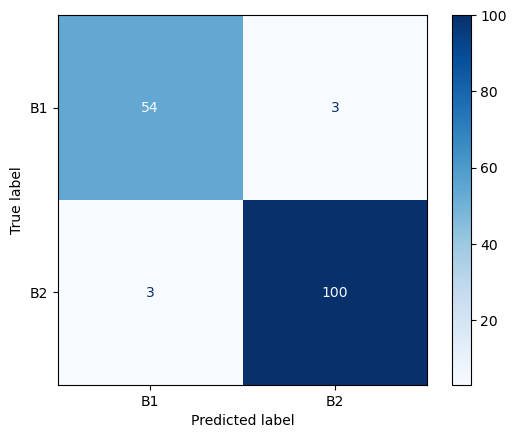

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import HistGradientBoostingClassifier, HistGradientBoostingRegressor

# Import SNR data from Excel
#readpath = r'C:\Users\Ruben\OneDrive - University of Cambridge\PhD\BSPM_for_ECGi\Publications\Wireless 3D Stacking of High Density E-textile Eutectogel Electrode Arrays for Cutaneous Electrophysiology\Experiments\INTAN\Data\ECG_classification\Delay_feature_matrix.xlsx'
# readpath = r'/Users/arzina/Library/CloudStorage/OneDrive-UniversityofCambridge/11B/4TH YR PROJECT/Delays_rawdata_tol20/P18-26_Delays_tol20.xlsx'
#readpath = r'/Users/arzina/Library/CloudStorage/OneDrive-UniversityofCambridge/11B/4TH YR PROJECT/threePC_Delays.xlsx'
readpath = r'/Users/arzina/Library/CloudStorage/OneDrive-UniversityofCambridge/11B/4TH YR PROJECT/FeatureMatrices/fhigh20/V2-V3/delays/delays_SCALEDPERPATIENT.xlsx'#ORIGINAL.xlsx'
df = pd.read_excel(io=readpath)
# Generate feature matrix from data
fmatrix = df
# Separate features and labels
X = fmatrix.drop('stage',axis=1).drop('patient',axis=1)  # feature matrix
y = fmatrix['stage']  # labels
# Standardise the data
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X),columns=X.columns)

totalcm = 0

#num_times = 100
#for i in range(num_times):
# Split the data into training and testing sets
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,stratify=fmatrix['stage'])

# Initialise and fit the logistic regression
clf = LogisticRegression()
#clf = HistGradientBoostingClassifier()

# Repeated Cross-Validation Accuracy
rkf = RepeatedStratifiedKFold(n_splits=20,n_repeats=10)
scores = cross_val_score(clf,X,y,cv=rkf)
print(f'Repeated Cross-Validation Accuracy: {scores.mean():.2f} ± {scores.std():.2f}')

clf.fit(X_train,y_train)
# Predict the labels for the test set
y_pred = clf.predict(X_test)
# Calculate the confusion matrix
cm = confusion_matrix(y_test,y_pred)
#totalcm += cm

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
disp.plot(cmap="Blues")

print("Intercept:", clf.intercept_)
print("Coefficients:", clf.coef_)


#### Test and train data are stored in different files

In [ ]:
import pandas as pd
import numpy as np
import os, glob, re
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score, StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.ensemble import HistGradientBoostingClassifier
import matplotlib.pyplot as plt

# Import data from Excel
def getXYdata(readpath):
    df = pd.read_excel(io=readpath)
    # Generate feature matrix from data
    fmatrix = df#.sample(frac = 1)
    # Separate features and labels
    Xtest = fmatrix.drop('stage',axis=1)  # feature matrix
    Xtest = Xtest.values
    
    ytest = fmatrix['stage']  # labels
    ytest = ytest.values
    #u = np.unique(ytest)
    #print('u', u)
    # Standardise the data
    return Xtest, ytest


def runLogisticRegression(readpath_train, readpath_test):
    #readpath_train = r'/Users/arzina/Library/CloudStorage/OneDrive-UniversityofCambridge/11B/4TH YR PROJECT/Delays_rawdata_tol60/not26.xlsx'
    #readpath_test = r'/Users/arzina/Library/CloudStorage/OneDrive-UniversityofCambridge/11B/4TH YR PROJECT/Delays_rawdata_tol60/Perpatient/P26.xlsx'

    scaler = StandardScaler()
    Xtrain, ytrain = getXYdata(readpath_train)
    #print('y_train', ytrain)
    Xtrain = scaler.fit_transform(Xtrain)  # pd.DataFrame,columns=Xtrain.columns
    Xtest, ytest = getXYdata(readpath_test)
    #print('Xtest', Xtest)
    #print('ytest', ytest)
    Xtest = scaler.transform(Xtest)  # , columns=Xtrain.columns ; Apply the *already fitted* scaler to the test data (DO NOT FIT AGAIN)

    # Initialise and fit the logistic regression
    clf = LogisticRegression(class_weight='balanced')#HistGradientBoostingClassifier()  #LogisticRegression()#

    clf.fit(Xtrain,ytrain)

    

    # Predict the labels for the test set
    y_pred = clf.predict(Xtest)
    print('y_pred', y_pred)
    # Calculate the confusion matrix
    cm = confusion_matrix(ytest,y_pred)

    print(cm)

    print(clf.classes_)
    # Display the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
    disp.plot(cmap="Blues")

    print(classification_report(ytest, y_pred, target_names=clf.classes_))

    return cm, clf.classes_

y_pred ['B1' 'B2' 'B1' 'B1' 'B1' 'B1' 'B1' 'B1' 'B1' 'B1' 'B1' 'B1']
[[ 0  0]
 [11  1]]
['B1' 'B2']
              precision    recall  f1-score   support

          B1       0.00      0.00      0.00         0
          B2       1.00      0.08      0.15        12

    accuracy                           0.08        12
   macro avg       0.50      0.04      0.08        12
weighted avg       1.00      0.08      0.15        12



/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.



' directory = r\'/Users/arzina/Library/CloudStorage/OneDrive-UniversityofCambridge/11B/4TH YR PROJECT/Delays_thirdof3peaks/Perpatient/\'\n\n# Apply function to all files in read directory\n# apply2all(read_directory=readpath,extension=\'.bspm\',func=fun2)\n\nos.chdir(directory) # move to the search directory\nxlsx_files = [f for f in glob.glob("*.xlsx")] # will produce a list of .xlsx files\n\nprint(\'xlsx_files\', xlsx_files)\n\nfor file in xlsx_files:\n\n    print(\'testing file\', file)\n    testpath = os.path.join(directory, file)\n    trainpath = r\'/Users/arzina/Library/CloudStorage/OneDrive-UniversityofCambridge/11B/4TH YR PROJECT/Delays_thirdof3peaks/not\'+file\n    \n    runLogisticRegression(readpath_train = trainpath, readpath_test = testpath)\n    plt.show() '

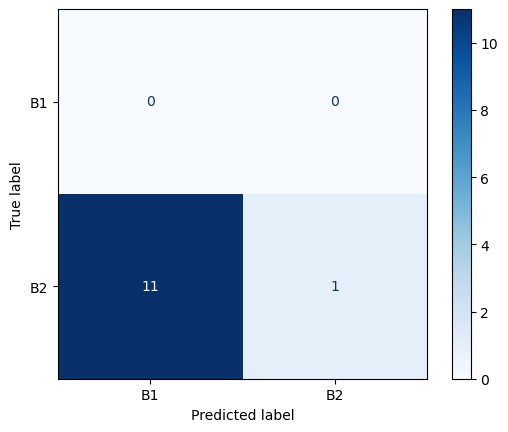

In [ ]:
readpath_train = r'/Users/arzina/Library/CloudStorage/OneDrive-UniversityofCambridge/11B/4TH YR PROJECT/Delays_thirdof3peaks/all_fs2000.xlsx'
readpath_test = r'/Users/arzina/Library/CloudStorage/OneDrive-UniversityofCambridge/11B/4TH YR PROJECT/Delays_thirdof3peaks/rotate_manualDelays_P22.xlsx'#3extremes.xlsx'
runLogisticRegression(readpath_train, readpath_test)

cm, clfClasses = runLogisticRegression(readpath_train, readpath_test)

patientnum = 22

AccAndConsistency(cm, clfClasses, acc_cons_path, patientnum)

""" directory = r'/Users/arzina/Library/CloudStorage/OneDrive-UniversityofCambridge/11B/4TH YR PROJECT/Delays_thirdof3peaks/Perpatient/'

# Apply function to all files in read directory
# apply2all(read_directory=readpath,extension='.bspm',func=fun2)

os.chdir(directory) # move to the search directory
xlsx_files = [f for f in glob.glob("*.xlsx")] # will produce a list of .xlsx files

print('xlsx_files', xlsx_files)

for file in xlsx_files:

    print('testing file', file)
    testpath = os.path.join(directory, file)
    trainpath = r'/Users/arzina/Library/CloudStorage/OneDrive-UniversityofCambridge/11B/4TH YR PROJECT/Delays_thirdof3peaks/not'+file
    
    runLogisticRegression(readpath_train = trainpath, readpath_test = testpath)
    plt.show() """

#### Excel file has patients labelled in it (Test data is data from a single patient, which is not within training data)

##### Scaling

In [8]:
import pandas as pd
import os
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score, StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler, RobustScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
#datapath = r'/Users/arzina/Library/CloudStorage/OneDrive-UniversityofCambridge/11B/4TH YR PROJECT/Delays_thirdof3peaks/all_fs2000.xlsx'
#datapath = r'/Users/arzina/Library/CloudStorage/OneDrive-UniversityofCambridge/11B/4TH YR PROJECT/threePC_Delays.xlsx'
#datapath = r'/Users/arzina/Library/CloudStorage/OneDrive-UniversityofCambridge/11B/4TH YR PROJECT/Delays_thirdof3peaks/all_fs2000_std_iqr.xlsx'

addon = 'all_fs2000WIDTHSPCA1-101517.xlsx'#'all_fs2000ORIGINAL.xlsx'#'all_fs2000GRADANGLE.xlsx'#'all_fs2000GRADMAG.xlsx'#'all_fs2000ORIGINAL.xlsx'

datapath = r'/Users/arzina/Library/CloudStorage/OneDrive-UniversityofCambridge/11B/4TH YR PROJECT/FeatureMatrices/fhigh20/V1/hfd/hfd_GRADANGLE_STANDARDISED.xlsx'#delays/delays_SCALEDPERPATIENT.xlsx'#1/widths/widths.xlsx'#Delays_thirdof3peaks/Delays_SearchWdw100/' + addon
#datapath = r'/Users/arzina/Library/CloudStorage/OneDrive-UniversityofCambridge/11B/4TH YR PROJECT/Delays_thirdof3peaks/' + addon

#save_pth = r'/Users/arzina/Library/CloudStorage/OneDrive-UniversityofCambridge/11B/4TH YR PROJECT/Delays_thirdof3peaks/Delays_SearchWdw100/all_fs2000WIDTHSPCA101517.xlsx'
df = pd.read_excel(io=datapath)

acc_cons_path = r'/Users/arzina/Library/CloudStorage/OneDrive-UniversityofCambridge/11B/4TH YR PROJECT/FeatureMatrices/fhigh20/V1/hfd/AccConsistencyLogisticRegression.xlsx' #+ addon
#fmatrix = df.copy()

#df_4chs = fmatrix[['Delay_ch11', 'Delay_ch12', 'Delay_ch16', 'Delay_ch4','Delay_ch5','Delay_ch17', 'stage', 'patient']]

#print(df_4chs)

#df_not23 = fmatrix.query("patient != 23")
#print(df.dtypes)

print(df)

     Grad_angle_ch10  Grad_angle_ch11  Grad_angle_ch12  Grad_angle_ch13  \
0           0.280724         1.663125        -0.974540        -1.133014   
1          -0.958423         0.285200        -1.290594         0.095389   
2          -0.851878         1.694461        -0.796367        -0.056819   
3           1.691775         1.236049        -0.811588        -0.194701   
4          -0.296769        -1.167932        -0.553731        -1.165246   
..               ...              ...              ...              ...   
438        -0.403314        -0.995132        -1.236873         1.025644   
439        -0.268118        -1.001400        -1.141072         0.927157   
440        -0.256479        -1.030050        -1.337151         1.003261   
441        -0.423012        -0.669229        -1.362221         1.486743   
442        -0.468674        -0.936040        -0.908285        -1.344314   

     Grad_angle_ch14  Grad_angle_ch15  Grad_angle_ch16  Grad_angle_ch17  \
0          -0.893959    

test_patientnum 18
  Class  Accuracy  Consistency  Support  Patient tested on
0    B2     0.529        0.529       68                 18
Excel file created with new data.
test_patientnum 19
  Class  Accuracy  Consistency  Support  Patient tested on
0    B1      0.09         0.91       78                 19
Data merged and saved to Excel file.
test_patientnum 21
  Class  Accuracy  Consistency  Support  Patient tested on
0    B1       1.0          1.0       52                 21
Data merged and saved to Excel file.
test_patientnum 22
  Class  Accuracy  Consistency  Support  Patient tested on
0    B2     0.611        0.611       18                 22
Data merged and saved to Excel file.
test_patientnum 23
  Class  Accuracy  Consistency  Support  Patient tested on
0    B2     0.628        0.628       43                 23
Data merged and saved to Excel file.
test_patientnum 24
  Class  Accuracy  Consistency  Support  Patient tested on
0    B1     0.333        0.667       15                

ValueError: Found array with 0 sample(s) (shape=(0, 18)) while a minimum of 1 is required by RobustScaler.

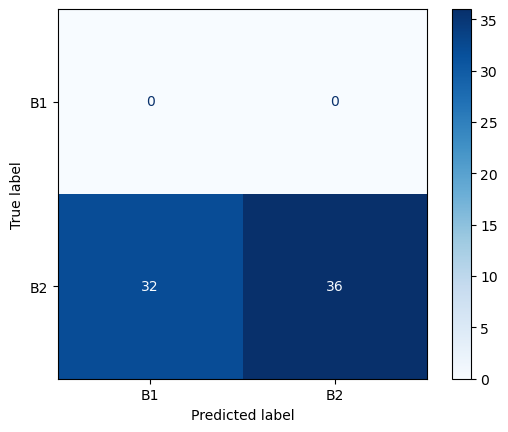

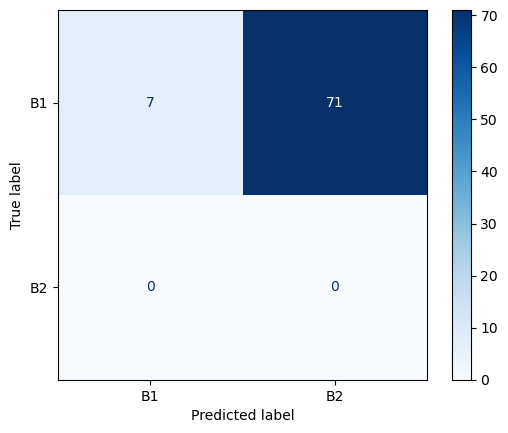

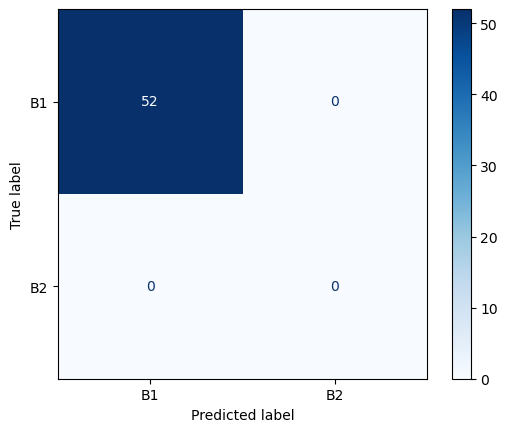

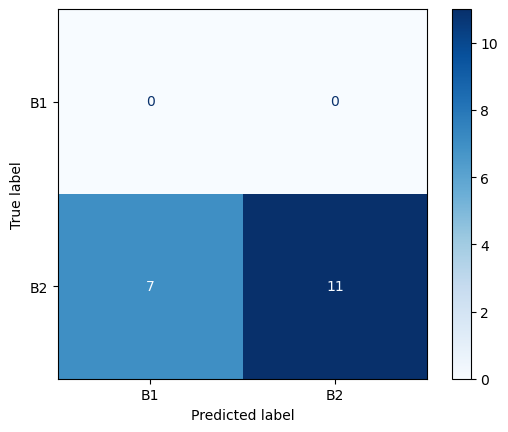

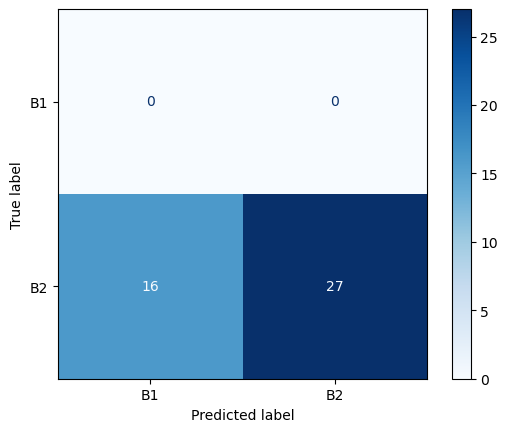

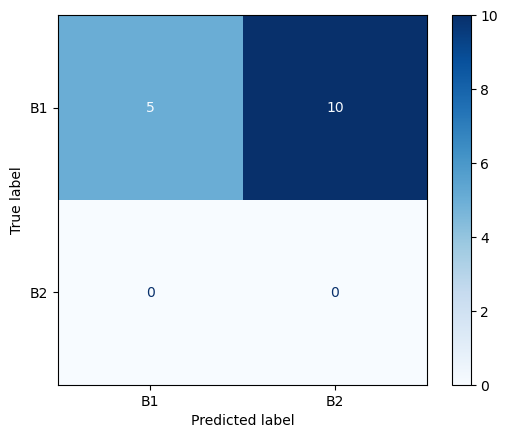

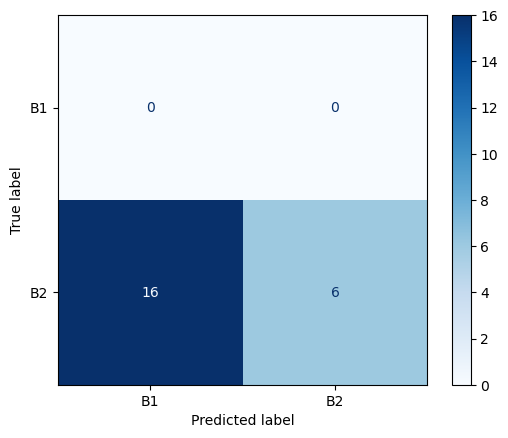

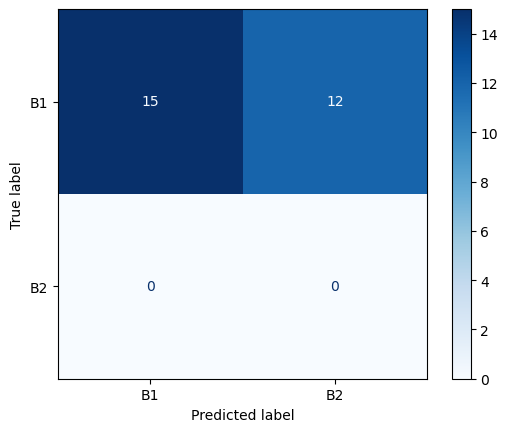

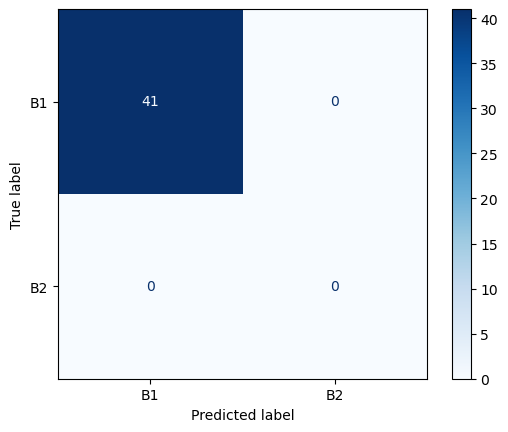

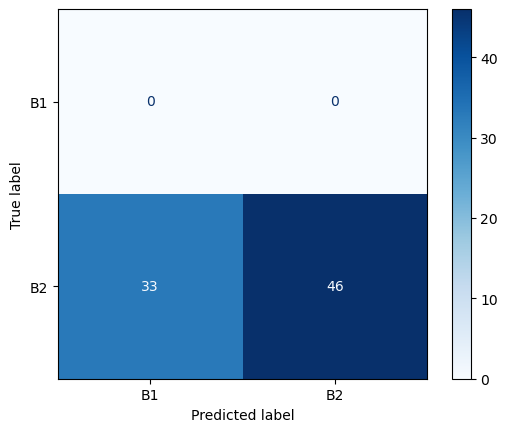

In [9]:
# Import data from Excel
def getXYdata(df_test):

    fmatrix = df_test.copy()

    Xtest = fmatrix.drop('patient', axis = 1).drop('stage', axis =1).drop('timestamp', axis =1).drop('search_window',axis=1)#feature matrix
    Xtest = Xtest.values
    
    ytest = fmatrix['stage']  # labels
    ytest = ytest.values
    #u = np.unique(ytest)
    #print('u', u)
    # Standardise the data
    return Xtest, ytest

def runRegression(df):
    patients = [18,19,21,22,23,24,25,26,27,28,29] # 18,19,21,22,23, i think 19? and 23 are correctly classified

    for test_patientnum in patients:

        print('test_patientnum', test_patientnum)

        df_test = df.query(f"patient == {test_patientnum}")

        Xtest, ytest = getXYdata(df_test)

        df_train = df.query(f"patient != {test_patientnum}")

        Xtrain, ytrain = getXYdata(df_train)

        scaler = RobustScaler()#MinMaxScaler()#Normalizer()# StandardScaler()
        Xtrain = scaler.fit_transform(Xtrain)  # pd.DataFrame,columns=Xtrain.columns
        Xtest = scaler.transform(Xtest)  # , columns=Xtrain.columns ; Apply the *already fitted* scaler to the test data (DO NOT FIT AGAIN)

        #print(Xtrain)

        # Initialise and fit the logistic regression
        clf = LogisticRegression(class_weight='balanced')#HistGradientBoostingClassifier()  #LogisticRegression()#


        #clf = SVC(kernel='rbf', gamma=best_params['gamma'], C=best_params['C'], class_weight='balanced',probability=True)
        #clf = DecisionTreeClassifier(class_weight='balanced')
        #clf = HistGradientBoostingClassifier(class_weight='balanced')
        #clf = LinearSVC(class_weight='balanced')
        
        clf.fit(Xtrain,ytrain)

        # Predict the labels for the test set
        y_pred = clf.predict(Xtest)
        #print('y_pred', y_pred)
        # Calculate the confusion matrix
        cm = confusion_matrix(ytest,y_pred,labels=clf.classes_)

        #print(cm)

        #print(clf.classes_)
        # Display the confusion matrix
        disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
        disp.plot(cmap="Blues")

        #print(classification_report(ytest, y_pred, target_names=clf.classes_))

        AccAndConsistency(cm, clf.classes_, acc_cons_path, test_patientnum)

runRegression(df)

##### No scaling

In [18]:
import numpy as np
import plotly.graph_objs as go
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.inspection import DecisionBoundaryDisplay

from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.inspection import DecisionBoundaryDisplay
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import numpy as np

def plot_logistic_regression_decision_boundary_2d(clf, X, y, feature_names=None):
    """
    Plot 2D PCA projection of logistic regression decision boundaries.
    Note: Your actual model uses more features; this is just a visualization.
    """
    # Encode labels
    le = LabelEncoder()
    y_numeric = le.fit_transform(y)
    
    # Reduce features to 2D using PCA
    pca = PCA(n_components=2)
    X_2d = pca.fit_transform(X)

    # Train logistic regression on 2D-projected data
    logreg_2d = LogisticRegression(
        C=clf.C,
        penalty=clf.penalty,
        solver=clf.solver,
        class_weight='balanced',
        max_iter=clf.max_iter,
        random_state=clf.random_state
    )
    logreg_2d.fit(X_2d, y_numeric)

    # Create plot
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Color map
    cmap = ListedColormap(plt.cm.Spectral(np.linspace(0, 1, len(le.classes_))))
    
    # Plot decision boundary
    DecisionBoundaryDisplay.from_estimator(
        logreg_2d, X_2d, response_method="predict", cmap=cmap, alpha=0.8, ax=ax
    )
    
    # Label axes
    if feature_names is not None and len(feature_names) >= 2:
        ax.set_xlabel(feature_names[0])
        ax.set_ylabel(feature_names[1])
    else:
        ax.set_xlabel("Principal Component 1")
        ax.set_ylabel("Principal Component 2")
    
    # Scatter points
    scatter = ax.scatter(X_2d[:, 0], X_2d[:, 1], c=y_numeric, s=50, edgecolors="k", cmap=cmap)
    
    # Legend
    legend_labels = le.inverse_transform(range(len(le.classes_)))
    legend = ax.legend(scatter.legend_elements()[0], legend_labels, title="Classes")
    ax.add_artist(legend)
    
    plt.title("Logistic Regression Decision Boundary (2D PCA Projection)")
    plt.show()


In [25]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score, StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
#datapath = r'/Users/arzina/Library/CloudStorage/OneDrive-UniversityofCambridge/11B/4TH YR PROJECT/Delays_thirdof3peaks/all_fs2000.xlsx'

#addon = 'all_fs2000WIDTHS10.xlsx'#'all_fs2000ORIGINAL.xlsx'#'all_fs2000GRADANGLE.xlsx'#'all_fs2000GRADMAG.xlsx'#'all_fs2000ORIGINAL.xlsx'

#datapath = r'/Users/arzina/Library/CloudStorage/OneDrive-UniversityofCambridge/11B/4TH YR PROJECT/Delays_thirdof3peaks/Delays_SearchWdw100/' + addon
#addon = 'all_fs2000SW100and350'
#datapath = r'/Users/arzina/Library/CloudStorage/OneDrive-UniversityofCambridge/11B/4TH YR PROJECT/Delays_thirdof3peaks/Delays_SearchWdw100/' + addon +r'GRADMAG.xlsx'

datapath = r'/Users/arzina/Desktop/HFD.xlsx'#r'/Users/arzina/Library/CloudStorage/OneDrive-UniversityofCambridge/11B/4TH YR PROJECT/FeatureMatrices/V1/delays_SCALEDPERPATIENT.xlsx'

df = pd.read_excel(io=datapath)

acc_cons_path = r'/Users/arzina/Desktop/HFD_acc_cons.xlsx'#r'/Users/arzina/Library/CloudStorage/OneDrive-UniversityofCambridge/11B/4TH YR PROJECT/FeatureMatrices/AccConsistency/widths_SCALEDPERPATIENT_PC2.xlsx'
#fmatrix = df.copy()

#datapath = r'/Users/arzina/Library/CloudStorage/OneDrive-UniversityofCambridge/11B/4TH YR PROJECT/Delays_thirdof3peaks/' + addon

#fmatrix = df.copy()

#df_4chs = fmatrix[['Delay_ch11', 'Delay_ch12', 'Delay_ch16', 'Delay_ch4','Delay_ch5','Delay_ch17', 'stage', 'patient']]

#print(df_4chs)

#df_not23 = fmatrix.query("patient != 23")
# 
# # Import data from Excel
def getXYdata(df_test):

    fmatrix = df_test.copy()

    Xtest = fmatrix.drop('stage',axis=1).drop('patient',axis=1)  # feature matrix
    Xtest = Xtest.values
    
    ytest = fmatrix['stage']  # labels
    ytest = ytest.values
    #u = np.unique(ytest)
    #print('u', u)
    # Standardise the data
    return Xtest, ytest

def runRegression(df):
    patients = [18,21,22,23,24,25,26,27,28,29] # 19? and 23 are correctly classified

    for test_patientnum in patients:

        print('test_patientnum', test_patientnum)

        df_test = df.query(f"patient == {test_patientnum}")

        Xtest, ytest = getXYdata(df_test)

        df_train = df.query(f"patient != {test_patientnum}")

        Xtrain, ytrain = getXYdata(df_train)

        #scaler = StandardScaler()
        #Xtrain = scaler.fit_transform(Xtrain)  # pd.DataFrame,columns=Xtrain.columns
        #Xtest = scaler.transform(Xtest)  # , columns=Xtrain.columns ; Apply the *already fitted* scaler to the test data (DO NOT FIT AGAIN)

        # Initialise and fit the logistic regression
        clf = LogisticRegression(class_weight='balanced')#HistGradientBoostingClassifier()  #LogisticRegression()#

        clf.fit(Xtrain,ytrain)

        # Predict the labels for the test set
        y_pred = clf.predict(Xtest)
        #print('y_pred', y_pred)
        # Calculate the confusion matrix
        #cm = confusion_matrix(ytest,y_pred)
        cm = confusion_matrix(ytest,y_pred,labels=clf.classes_)
        #print(cm)

        #print(clf.classes_)
        # Display the confusion matrix
        #disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
        #disp.plot(cmap="Blues")

        #print(classification_report(ytest, y_pred, target_names=clf.classes_))
        #plot_logistic_regression_decision_boundary_2d(clf, Xtrain, ytrain, feature_names=None)
        AccAndConsistency(cm, clf.classes_, acc_cons_path, test_patientnum)


runRegression(df)

test_patientnum 18
  Class  Accuracy  Consistency  Support  Patient tested on
0    B2       1.0          1.0       67                 18
Excel file created with new data.
test_patientnum 21
  Class  Accuracy  Consistency  Support  Patient tested on
0    B1       1.0          1.0       27                 21
Data merged and saved to Excel file.
test_patientnum 22
  Class  Accuracy  Consistency  Support  Patient tested on
0    B2       0.0          1.0       28                 22
Data merged and saved to Excel file.
test_patientnum 23
  Class  Accuracy  Consistency  Support  Patient tested on
0    B2       1.0          1.0       41                 23
Data merged and saved to Excel file.
test_patientnum 24
  Class  Accuracy  Consistency  Support  Patient tested on
0    B1       1.0          1.0       47                 24
Data merged and saved to Excel file.
test_patientnum 25
  Class  Accuracy  Consistency  Support  Patient tested on
0    B2       1.0          1.0       22                

##### Scaling each patient individually

In [3]:
def writeDFtoExcel(save_pth, df):
    try:
        existing_df = pd.read_excel(save_pth)
        # Append the new data to the existing data
        combined_df = pd.concat([existing_df,df],ignore_index=True)
    except FileNotFoundError:
        # If the file doesn't exist, just use the new data
        combined_df = df

    # Write the combined data back to the Excel file
    with pd.ExcelWriter(save_pth,mode='w',engine='openpyxl') as writer:
        combined_df.to_excel(writer,index=False)
        print('put into excel') 
        
#addons = ['all_fs2000ORIGINAL','all_fs2000AMPS']#'all_fs2000GRADANGLE'##.xlsx''#'all_fs2000GRADMAG'#'all_fs2000ORIGINAL.xlsx'
#for addon in addons:
#datapath = r'/Users/arzina/Library/CloudStorage/OneDrive-UniversityofCambridge/11B/4TH YR PROJECT/Delays_thirdof3peaks/'+addon +'.xlsx'
# datapath = r'/Users/arzina/Library/CloudStorage/OneDrive-UniversityofCambridge/11B/4TH YR PROJECT/FeatureMatrices/delays.xlsx'
#datapath = r'/Users/arzina/Library/CloudStorage/OneDrive-UniversityofCambridge/11B/4TH YR PROJECT/threePC_Delays.xlsx'
datapath = r'/Users/arzina/Library/CloudStorage/OneDrive-UniversityofCambridge/11B/4TH YR PROJECT/FeatureMatrices/fhigh20/V1/delays/delays.xlsx'

df = pd.read_excel(io=datapath)

patients = [17,18,19,21,22,23,24,25,26,27,28,29]

for p in patients:

    df_p = df.query(f"patient == {p}")

    df_p_ch =df_p.drop('stage',axis=1).drop('patient',axis=1).drop('search_window',axis=1).drop('timestamp',axis=1)

    max_p = df_p_ch.max().max()
    
    print('max_p', max_p)
    
    max_p_abs = np.abs(df_p_ch).max().max()

    print('max_p_abs', max_p_abs)

    df_scaled = df_p_ch/max_p_abs

    df_scaled['stage'] = df_p['stage']
    df_scaled['patient'] = df_p['patient']
    df_scaled['search_window'] = df_p['search_window']
    df_scaled['timestamp'] = df_p['timestamp']

    print(df_scaled.shape)

    save_pth = r'/Users/arzina/Library/CloudStorage/OneDrive-UniversityofCambridge/11B/4TH YR PROJECT/FeatureMatrices/fhigh20/V1/delays/delays_SCALEDPERPATIENT.xlsx'

    writeDFtoExcel(save_pth, df_scaled)



max_p 19
max_p_abs 19
(6, 22)
put into excel
max_p 20
max_p_abs 20
(68, 22)
put into excel
max_p 16
max_p_abs 17
(54, 22)
put into excel
max_p 18
max_p_abs 20
(28, 22)
put into excel
max_p 20
max_p_abs 20
(29, 22)
put into excel
max_p 13
max_p_abs 20
(43, 22)
put into excel
max_p 20
max_p_abs 20
(48, 22)
put into excel
max_p 19
max_p_abs 19
(22, 22)
put into excel
max_p 17
max_p_abs 17
(27, 22)
put into excel
max_p 20
max_p_abs 20
(41, 22)
put into excel
max_p 15
max_p_abs 16
(79, 22)
put into excel
max_p 20
max_p_abs 20
(59, 22)
put into excel


test_patientnum 23


/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


ValueError: The number of FixedLocator locations (1), usually from a call to set_ticks, does not match the number of labels (2).

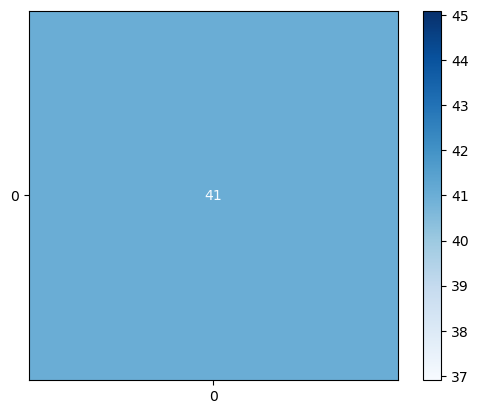

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score, StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
exl_pth = r'/Users/arzina/Library/CloudStorage/OneDrive-UniversityofCambridge/11B/4TH YR PROJECT/Delays_thirdof3peaks/all_fs2000_scaledindividually.xlsx'

df = pd.read_excel(io=exl_pth)


# # Import data from Excel
def getXYdata(df_test):

    fmatrix = df_test.copy()

    Xtest = fmatrix.drop('stage',axis=1).drop('patient',axis=1)  # feature matrix
    Xtest = Xtest.values
    
    ytest = fmatrix['stage']  # labels
    ytest = ytest.values
    #u = np.unique(ytest)
    #print('u', u)
    # Standardise the data
    return Xtest, ytest

def runRegression(df):
    patients = [23]#18,19,21,22,24,25,26] # 19? and 23 are correctly classified

    for test_patientnum in patients:

        print('test_patientnum', test_patientnum)

        df_test = df.query(f"patient == {test_patientnum}")

        Xtest, ytest = getXYdata(df_test)

        df_train = df.query(f"patient != {test_patientnum}")

        Xtrain, ytrain = getXYdata(df_train)

        # Initialise and fit the logistic regression
        clf = LogisticRegression(class_weight='balanced')#HistGradientBoostingClassifier()  #LogisticRegression()#

        clf.fit(Xtrain,ytrain)

        # Predict the labels for the test set
        y_pred = clf.predict(Xtest)
        #print('y_pred', y_pred)
        # Calculate the confusion matrix
        cm = confusion_matrix(ytest,y_pred)

        #print(cm)

        #print(clf.classes_)
        # Display the confusion matrix
        disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
        disp.plot(cmap="Blues")

        print(classification_report(ytest, y_pred, target_names=clf.classes_))

        

runRegression(df)

### Correlation Circles and PCA

##### Reading file

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from mlxtend.plotting import plot_pca_correlation_graph

readpath = #r'/Users/arzina/Library/CloudStorage/OneDrive-UniversityofCambridge/11B/4TH YR PROJECT/Delays_thirdof3peaks/all_fs2000ORIGINAL.xlsx'#delay_means.xlsx'#all_fs2000.xlsx'
#readpath = r'/Users/arzina/Library/CloudStorage/OneDrive-UniversityofCambridge/11B/4TH YR PROJECT/Delays_thirdof3peaks/all_fs2000_scaledindividually.xlsx'

df = pd.read_excel(io=readpath)
# checking shape
print('Original Dataframe shape :',df.shape)

#df = df.query(f"patient == {22}")

X = df.drop('stage',axis=1).drop('patient',axis=1)

# Input features
#X = df[cancer['feature_names']]
print('Inputs Dataframe shape   :', X.shape)

# Mean
X_mean = X.mean()

# Standard deviation
X_std = X.std()

# Standardization
Z = (X - X_mean) / X_std

#Z = StandardScaler().fit_transform(X)

SyntaxError: invalid syntax (3110158098.py, line 8)

#### Covariance matrix

In [6]:
# covariance - The covariance matrix helps us visualize how strong the dependency of two features 
# is with each other in the feature space.
c = Z.cov()

# Plot the covariance matrix
sns.heatmap(c)
plt.show()

NameError: name 'Z' is not defined

#### Plotting PCA Graphs

In [13]:
import pandas as pd
#addon = 'all_fs2000AMPSSW100and350'
#readpath = r'/Users/arzina/Library/CloudStorage/OneDrive-UniversityofCambridge/11B/4TH YR PROJECT/Delays_thirdof3peaks/Delays_SearchWdw100/' + addon +r'_SCALEDPERPATIENT.xlsx'
#addon = 'all_fs2000AMPS_SCALEDPERPATIENT_GRADMAG'#SW100and350'
#readpath = r'/Users/arzina/Desktop/HFD.xlsx'#'/Users/arzina/Library/CloudStorage/OneDrive-UniversityofCambridge/11B/4TH YR PROJECT/FeatureMatrices/widths_SCALEDPERPATIENT.xlsx'
readpath = r'/Users/arzina/Library/CloudStorage/OneDrive-UniversityofCambridge/11B/4TH YR PROJECT/FeatureMatrices/fhigh20/V1/delaysNOTIMESTAMPS/delays_SCALEDPERPATIENT.xlsx'#widths/widths.xlsx' # 2-V3/delays/delays_SCALEDPERPATIENT.xlsx'#
df = pd.read_excel(io=readpath)
# checking shape
print('Original Dataframe shape :',df.shape)

X = df.drop('stage',axis=1).drop('patient',axis=1).drop('search_window', axis = 1)#.drop('timestamp', axis = 1)

# Input features
#X = df[cancer['feature_names']]
print('Inputs Dataframe shape   :', X.shape)

Z = X

#print(Z)

Original Dataframe shape : (558, 21)
Inputs Dataframe shape   : (558, 18)


##### 2D PCA

          PC1       PC2
0   -0.293780  0.141537
1   -0.682337  0.328780
2   -0.269557  0.172631
3   -0.644850  0.268933
4   -0.299830  0.009949
..        ...       ...
553 -1.568691 -0.441149
554 -1.546465 -0.299719
555 -1.070559 -0.191513
556 -1.225509 -0.313669
557 -1.686781 -0.304419

[558 rows x 2 columns]


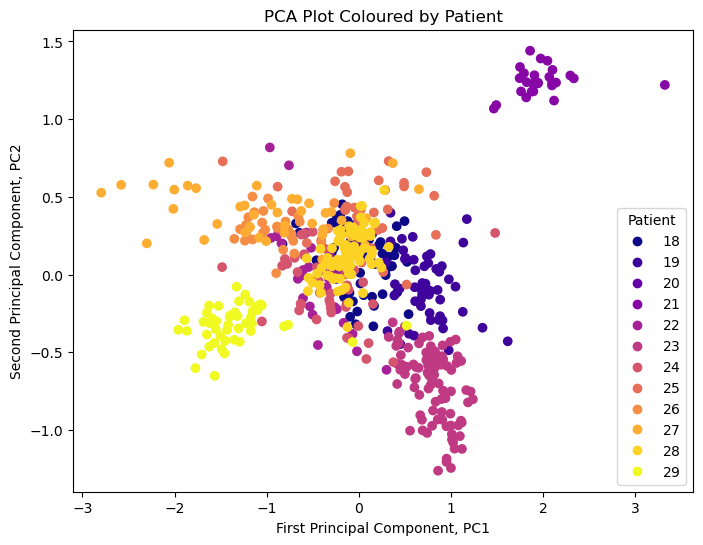

In [14]:
# Importing PCA
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


# Let's say, components = 2
n_components = 2
pca = PCA(n_components)
pca.fit(Z) # Fit the model with Z
x_pca = pca.transform(Z)  # Apply dimensionality reduction to Z --> output has shape 315 x 2

# Create the dataframe
df_pca1 = pd.DataFrame(x_pca, columns=['PC{}'.format(i+1) for i in range(n_components)])
print(df_pca1)


#df['stage_numeric'] = pd.Categorical(df['stage']).codes
#df['patient_numeric'] = pd.Categorical(df['patient']).codes


# giving a larger plot
plt.figure(figsize=(8, 6))

scatter = plt.scatter(x_pca[:, 0], x_pca[:, 1], c=df['patient'], # stage # patient
                      cmap='plasma')

# labeling x and y axes
plt.xlabel('First Principal Component, PC1')
plt.ylabel('Second Principal Component, PC2')
# Adding a title
plt.title('PCA Plot Coloured by Patient') # Stage

# Creating the legend with patient labels
handles, labels = scatter.legend_elements()
#print('legend_elements', scatter.legend_elements())
#print('labels', labels)
#print('handles', handles)
""" patientnum_labels = dict(enumerate(df['patient_numeric'].astype(str).unique()))
patient_labels = dict(enumerate(df['patient'].astype(str).unique()))
newdict = {}
for key in patient_labels:
    print(key, patient_labels[key], patientnum_labels[key])
    newdict[int(patientnum_labels[key])] = patient_labels[key]
print(newdict)
labels = [newdict[int(key)] for key in patient_labels]  # Replace numeric labels with patient names """


legend1 = plt.legend(handles, labels, loc="lower right", title="Patient") 

plt.show()

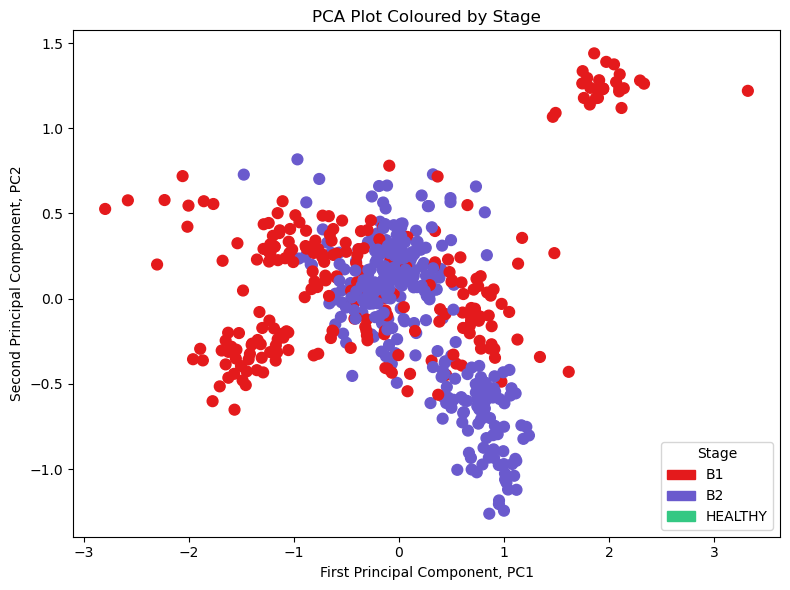

In [16]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pandas as pd

# Run PCA
pca = PCA(n_components=2)
x_pca = pca.fit_transform(Z)

# Convert STAGE to color
stage_colors = {'B1': '#e41a1c', 'B2': '#6a5acd', 'HEALTHY':"#34c883"}  # red and dark lilac-blue
colors = df['stage'].map(stage_colors)

# Plot
plt.figure(figsize=(8, 6))
scatter = plt.scatter(x_pca[:, 0], x_pca[:, 1],
                      c=colors, s=60)

# Label axes
plt.xlabel('First Principal Component, PC1')
plt.ylabel('Second Principal Component, PC2')
plt.title('PCA Plot Coloured by Stage')

# Custom legend
import matplotlib.patches as mpatches
legend_elements = [
    mpatches.Patch(color='#e41a1c', label='B1'),
    mpatches.Patch(color='#6a5acd', label='B2'),
    mpatches.Patch(color="#34c883", label='HEALTHY')
]
plt.legend(handles=legend_elements, loc='lower right', title='Stage')

plt.tight_layout()
plt.show()


##### 3D PCA interactive

In [17]:
import plotly.express as px
import pandas as pd
from sklearn.decomposition import PCA
import numpy as np

# Perform PCA
n_components = 3
pca = PCA(n_components=n_components)

x_pca = pca.fit_transform(Z)  # Apply dimensionality reduction
#print(pca.components_)

df_pca = pd.DataFrame(x_pca, columns=[f'PC{i+1}' for i in range(n_components)])
#df_pca['stage_numeric'] = pd.Categorical(df['stage']).codes
#df_pca['patient_numeric'] = pd.Categorical(df['patient']).codes

df_pca['stage'] = df['stage'].values  # Retaining original categorical labels
#df_pca['patient'] = df['patient']#.values


# Create interactive 3D scatter plot
fig = px.scatter_3d(df_pca, 
                     x='PC1', 
                     y='PC2', 
                     z='PC3', 
                     color='stage',#'patient', #stage
                     title='3D PCA Projection',
                     labels={'PC1': 'First Principal Component',
                             'PC2': 'Second Principal Component',
                             'PC3': 'Third Principal Component'},
                    color_continuous_scale='plasma',
                    size_max=3)  # Reduce point size

fig.update_traces(marker=dict(size=3))  # Adjust marker size

fig.update_layout(
    scene=dict(
        xaxis_title='PC1',
        yaxis_title='PC2',
        zaxis_title='PC3'),
    legend_title_text='Patient'
)

fig.show()


#### Clustering metrics

In [28]:
import pandas as pd
#addon = 'all_fs2000AMPSSW100and350'
#readpath = r'/Users/arzina/Library/CloudStorage/OneDrive-UniversityofCambridge/11B/4TH YR PROJECT/Delays_thirdof3peaks/Delays_SearchWdw100/' + addon +r'_SCALEDPERPATIENT.xlsx'
#addon = 'all_fs2000AMPS_SCALEDPERPATIENT_GRADMAG'#SW100and350'
#readpath = r'/Users/arzina/Desktop/HFD.xlsx'#'/Users/arzina/Library/CloudStorage/OneDrive-UniversityofCambridge/11B/4TH YR PROJECT/FeatureMatrices/widths_SCALEDPERPATIENT.xlsx'
#readpath = r'/Users/arzina/Library/CloudStorage/OneDrive-UniversityofCambridge/11B/4TH YR PROJECT/FeatureMatrices/fhigh20/V1//hfd_GRADANGLE.xlsx'
df = pd.read_excel(io=readpath)
# checking shape
print('Original Dataframe shape :',df.shape)

X_ = df.drop('patient',axis=1).drop('timestamp', axis = 1)#.drop('stage',axis=1)  # .drop('search_window', axis = 1)feature matrix

# Input features
#X = df[cancer['feature_names']]
print('Inputs Dataframe shape   :', X_.shape)

Z_ = X_

print(Z_)

Original Dataframe shape : (357, 57)
Inputs Dataframe shape   : (357, 55)
     Delay_ch10  Delay_ch11  Delay_ch12  Delay_ch13  Delay_ch14  Delay_ch15  \
0     -0.412326   -0.275663   -0.685651    1.090965    0.680977    0.270988   
1      0.134325    0.270988   -0.002337    1.090965    0.817639    0.544314   
2     -0.548988   -0.548988   -0.685651    0.817639    0.954302    0.270988   
3     -0.002337   -0.002337   -0.275663    1.090965    1.090965    0.680977   
4     -0.548988   -0.548988   -0.548988    1.227628    0.680977    0.134325   
..          ...         ...         ...         ...         ...         ...   
352    0.407651    0.270988    0.134325    0.954302    0.817639    0.817639   
353    0.544314    0.407651    0.134325    0.270988    0.544314    0.680977   
354    0.134325   -0.139000   -0.002337    0.680977    0.407651    0.407651   
355    0.680977    0.270988    0.544314    1.227628    0.954302    0.954302   
356    0.680977    0.270988    0.544314    1.227628    0.

In [96]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
s = silhouette_score(x_pca, labels=df_pca['stage'])
db = davies_bouldin_score(x_pca, labels=df_pca['stage'])
ch = calinski_harabasz_score(x_pca, labels=df_pca['stage'])

print(s, db, ch)


0.10942297995977583 2.6644057894797117 54.865988581417184


In [29]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

s = silhouette_score(Z_.drop('stage', axis=1), labels=Z_['stage'])
db = davies_bouldin_score(Z_.drop('stage', axis=1), labels=Z_['stage'])
ch = calinski_harabasz_score(Z_.drop('stage', axis=1), labels=Z_['stage'])

print(s, db, ch)

0.10145942754683165 3.367676103655837 27.961666946946483


##### Putting first 3 PCs into excel

In [17]:
# Importing PCA
from sklearn.decomposition import PCA

# Let's say, components = 2
n_components = 1
pca = PCA(n_components)
pca.fit(Z) # Fit the model with Z
x_pca = pca.transform(Z)  # Apply dimensionality reduction to Z --> output has shape 315 x 3

# Create the dataframe
df_pca1 = pd.DataFrame(x_pca, columns=['PC{}'.format(i+1) for i in range(n_components)])
#print(df_pca1)

#print(df['stage'])
#df['stage_numeric'] = pd.Categorical(df['stage']).codes

df_pca1['stage'] = df['stage']
df_pca1['patient'] = df['patient']

print(df_pca1)


#save_pth = r'/Users/arzina/Library/CloudStorage/OneDrive-UniversityofCambridge/11B/4TH YR PROJECT/threePC_Delays.xlsx'
#save_pth = r'/Users/arzina/Library/CloudStorage/OneDrive-UniversityofCambridge/11B/4TH YR PROJECT/Delays_thirdof3peaks/Delays_SearchWdw100/all_fs2000WIDTHSPCA101517.xlsx'#SW100and350.xlsx'#all_fs2000P23.xlsx'#all_fs2000AMPS_SCALEDPERPATIENT.xlsx'#_scaledindividually.xlsx'
save_pth = r'/Users/arzina/Desktop/HFD_PC1.xlsx'#r'/Users/arzina/Library/CloudStorage/OneDrive-UniversityofCambridge/11B/4TH YR PROJECT/FeatureMatrices/widths_SCALEDPERPATIENT_PC2.xlsx'

try:
    existing_df = pd.read_excel(save_pth)
    # Append the new data to the existing data
    combined_df = pd.concat([existing_df,df_pca1],ignore_index=True)
except FileNotFoundError:
    # If the file doesn't exist, just use the new data
    combined_df = df_pca1

# Write the combined data back to the Excel file
with pd.ExcelWriter(save_pth,mode='w',engine='openpyxl') as writer:
    combined_df.to_excel(writer,index=False)
    print('put into excel') 



          PC1 stage  patient
0   -3.637086    B2       18
1   -3.590522    B2       18
2   -3.687202    B2       18
3   -3.636960    B2       18
4   -3.591446    B2       18
..        ...   ...      ...
423 -0.639068    B2       28
424 -0.429431    B2       28
425 -0.603902    B2       28
426  0.419669    B2       28
427 -0.072109    B2       28

[428 rows x 3 columns]
put into excel


#### Correlation Circles

In [53]:
from mlxtend.plotting import plot_pca_correlation_graph

def plotCorrCircle(readpath, stage):

    df = pd.read_excel(io=readpath)
    # checking shape
    #print('Original Dataframe shape :',df.shape)
    #print(df.columns)


    #df_patient = df.query(f"patient == {patientnum}")
    df_patient = df.query(f"stage == 'HEALTHY'")

    #print('df_patient shape', df_patient.shape)

    #print('df_patient', df_patient)

    #print('df_patient.shape', df_patient.shape)
    
    #index_column = df_patient['stage']
    #print('index_column', index_column)

    delay_cols_df = df_patient.drop('stage',axis=1).drop('patient',axis=1).drop('search_window', axis = 1) #= [("Delay_ch"+str(ch)) for ch in rMP.preprocessed_data.columns[1:]]
    
    #for ch in range(10,20):
    #    delay_cols_df.drop('Delay_ch'+str(ch),axis=1)

    print(delay_cols_df.shape)
    #print('value_columns', value_columns)

    #df_filtered = pd.concat((index_column, value_columns))
    #print('df_filtered', df_filtered)

    X = delay_cols_df.copy()
    
    X_mean = X.mean()

    # Standard deviation
    X_std = X.std()

    # Standardization
    Z = (X - X_mean) / X_std
    #print(patientnum)
    #print(Z)

    # Input features
    #X = df[cancer['feature_names']]
    #print('Inputs Dataframe shape   :', Z.shape)

    #for ch in range(10,20):
    #    Z.drop(f'Delay_ch{ch}',axis=1)

    cols_labels = []
    for ch in range(2,20):
        cols_labels += [f'Delay_ch{ch}']

    figure, correlation_matrix = plot_pca_correlation_graph(Z, cols_labels, dimensions=(1, 2), figure_axis_size=20)


    plt.show()

    return figure, correlation_matrix


""" 
def plot_pca_correlation_graph(
    X,
    variables_names,
    dimensions=(1, 2),
    figure_axis_size=6,
    X_pca=None,
    explained_variance=None,
):
 """


' \ndef plot_pca_correlation_graph(\n    X,\n    variables_names,\n    dimensions=(1, 2),\n    figure_axis_size=6,\n    X_pca=None,\n    explained_variance=None,\n):\n '

stage, B B1
(6, 18)


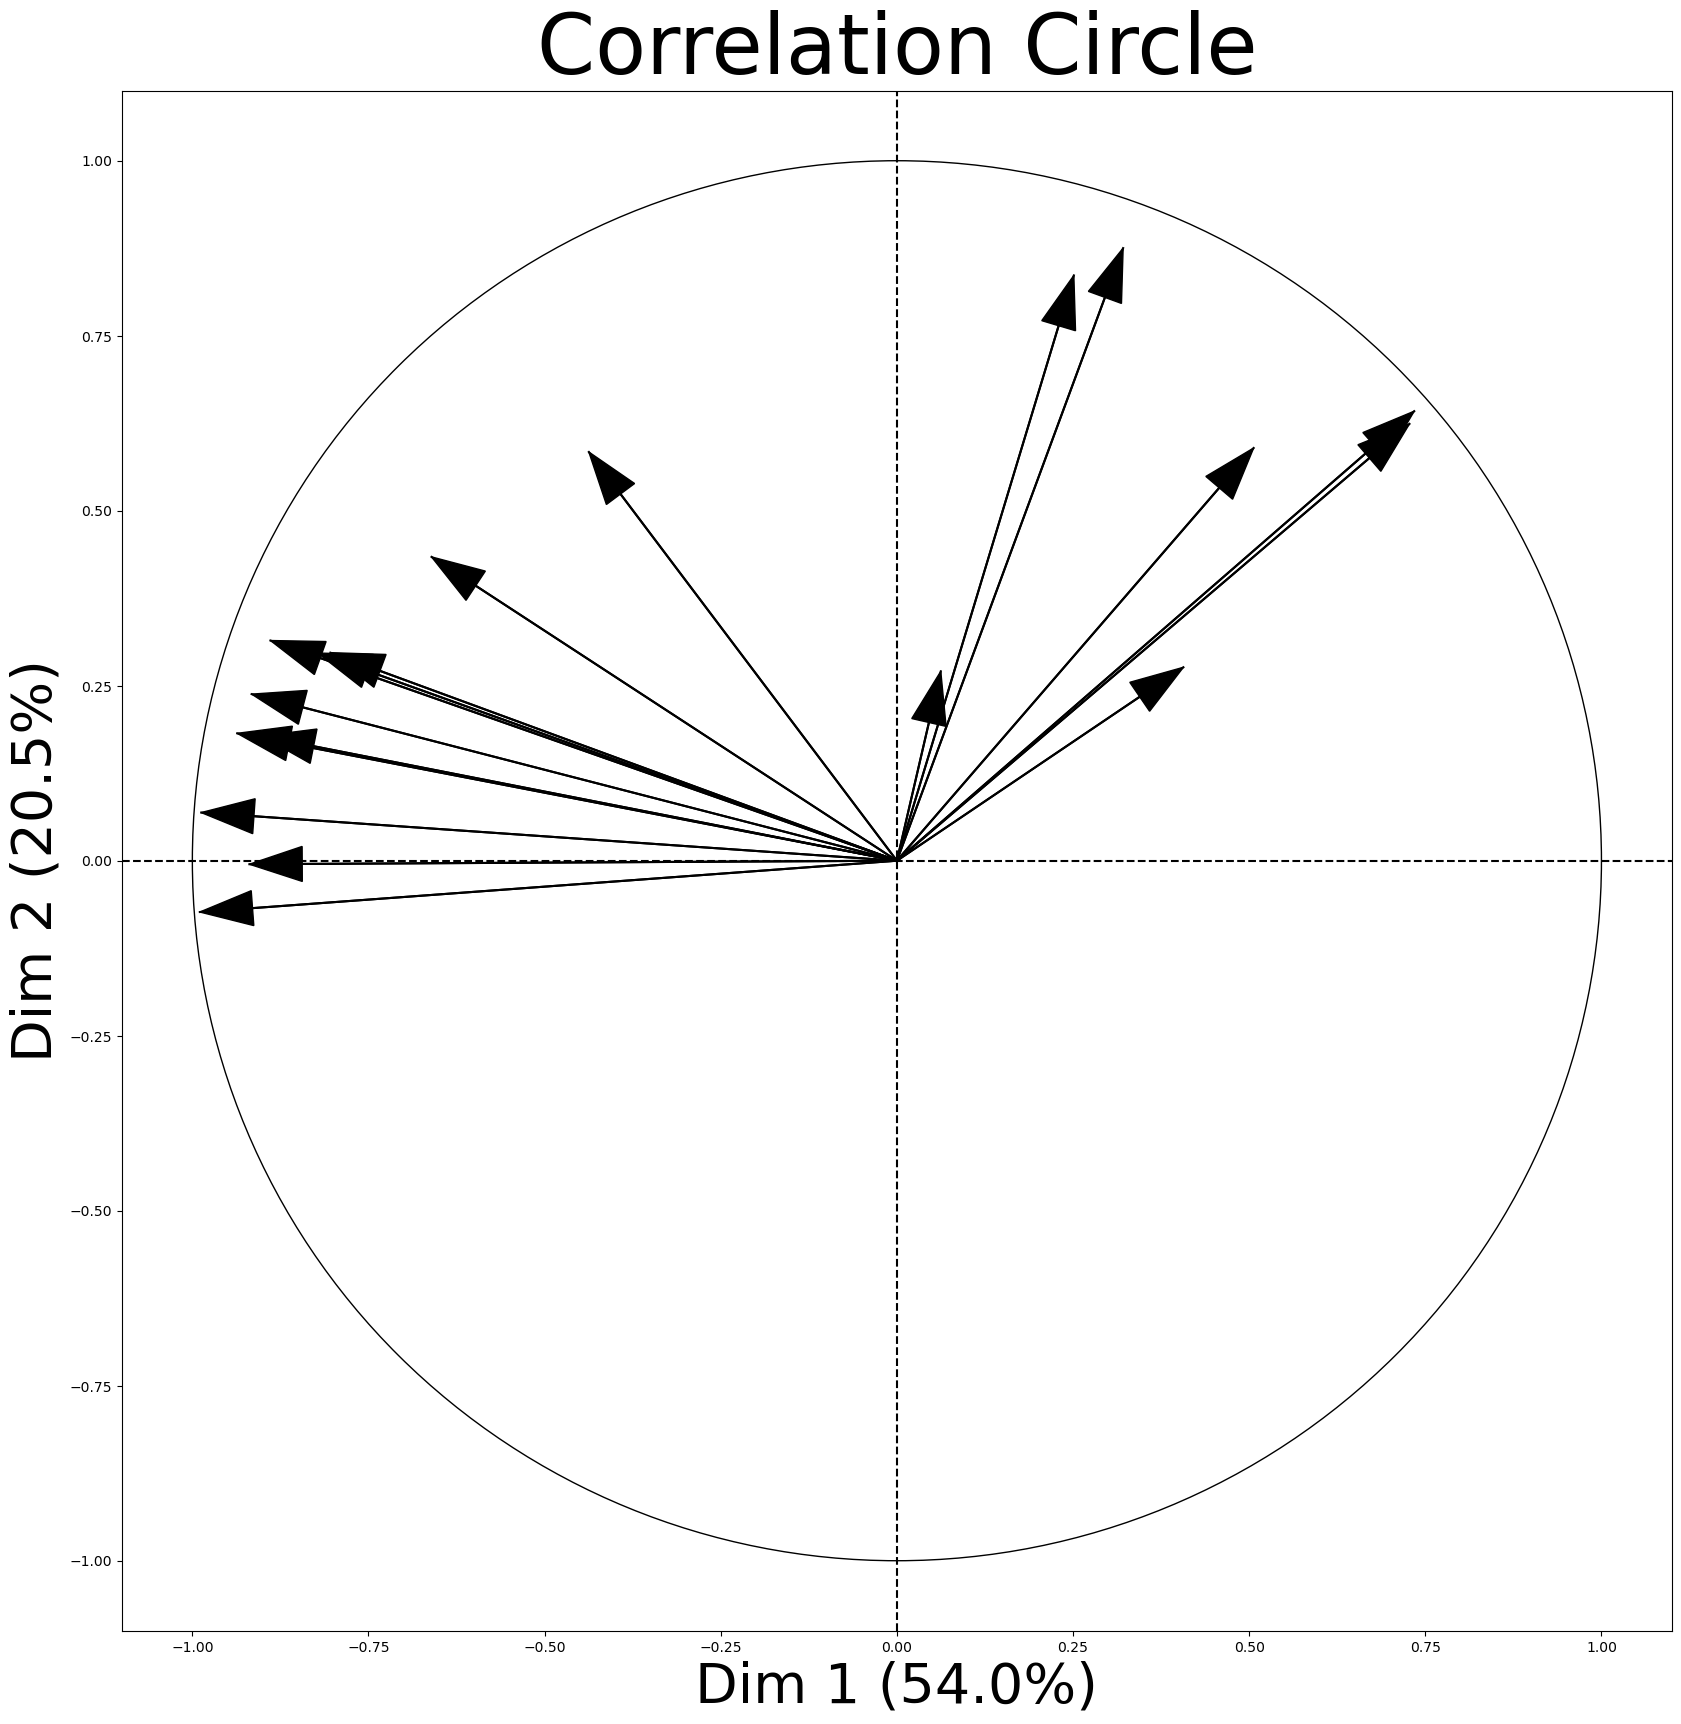

arrow < 0.8 ['Delay_ch2', 'Delay_ch8', 'Delay_ch11', 'Delay_ch12', 'Delay_ch13']
stage, B B2
(6, 18)


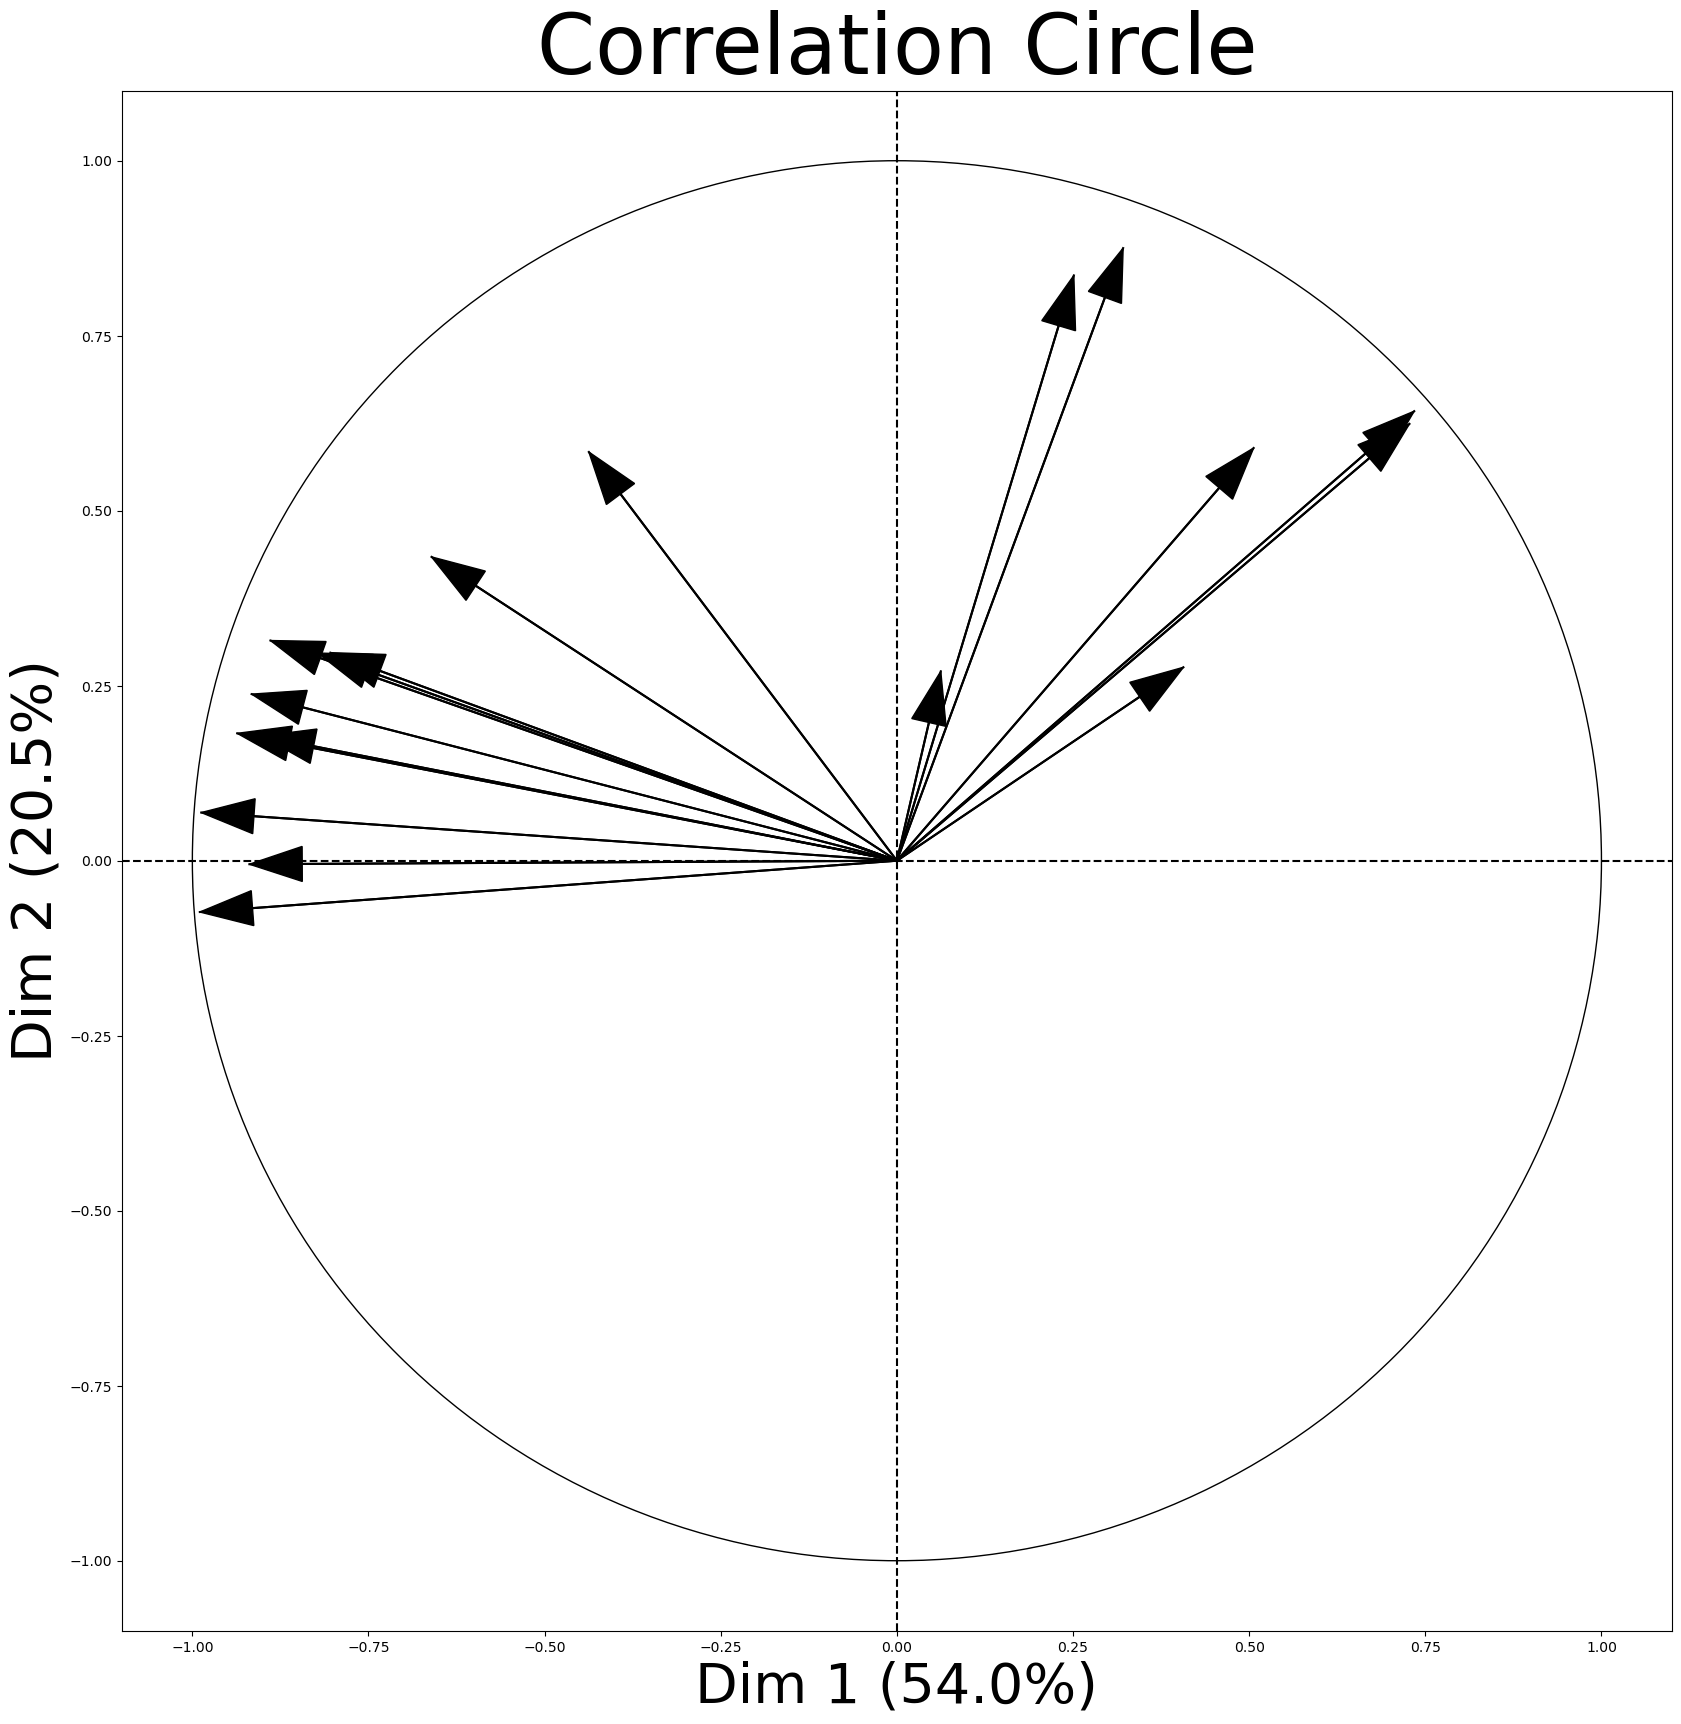

arrow < 0.8 ['Delay_ch2', 'Delay_ch8', 'Delay_ch11', 'Delay_ch12', 'Delay_ch13']
stage, B HEALHTY
(6, 18)


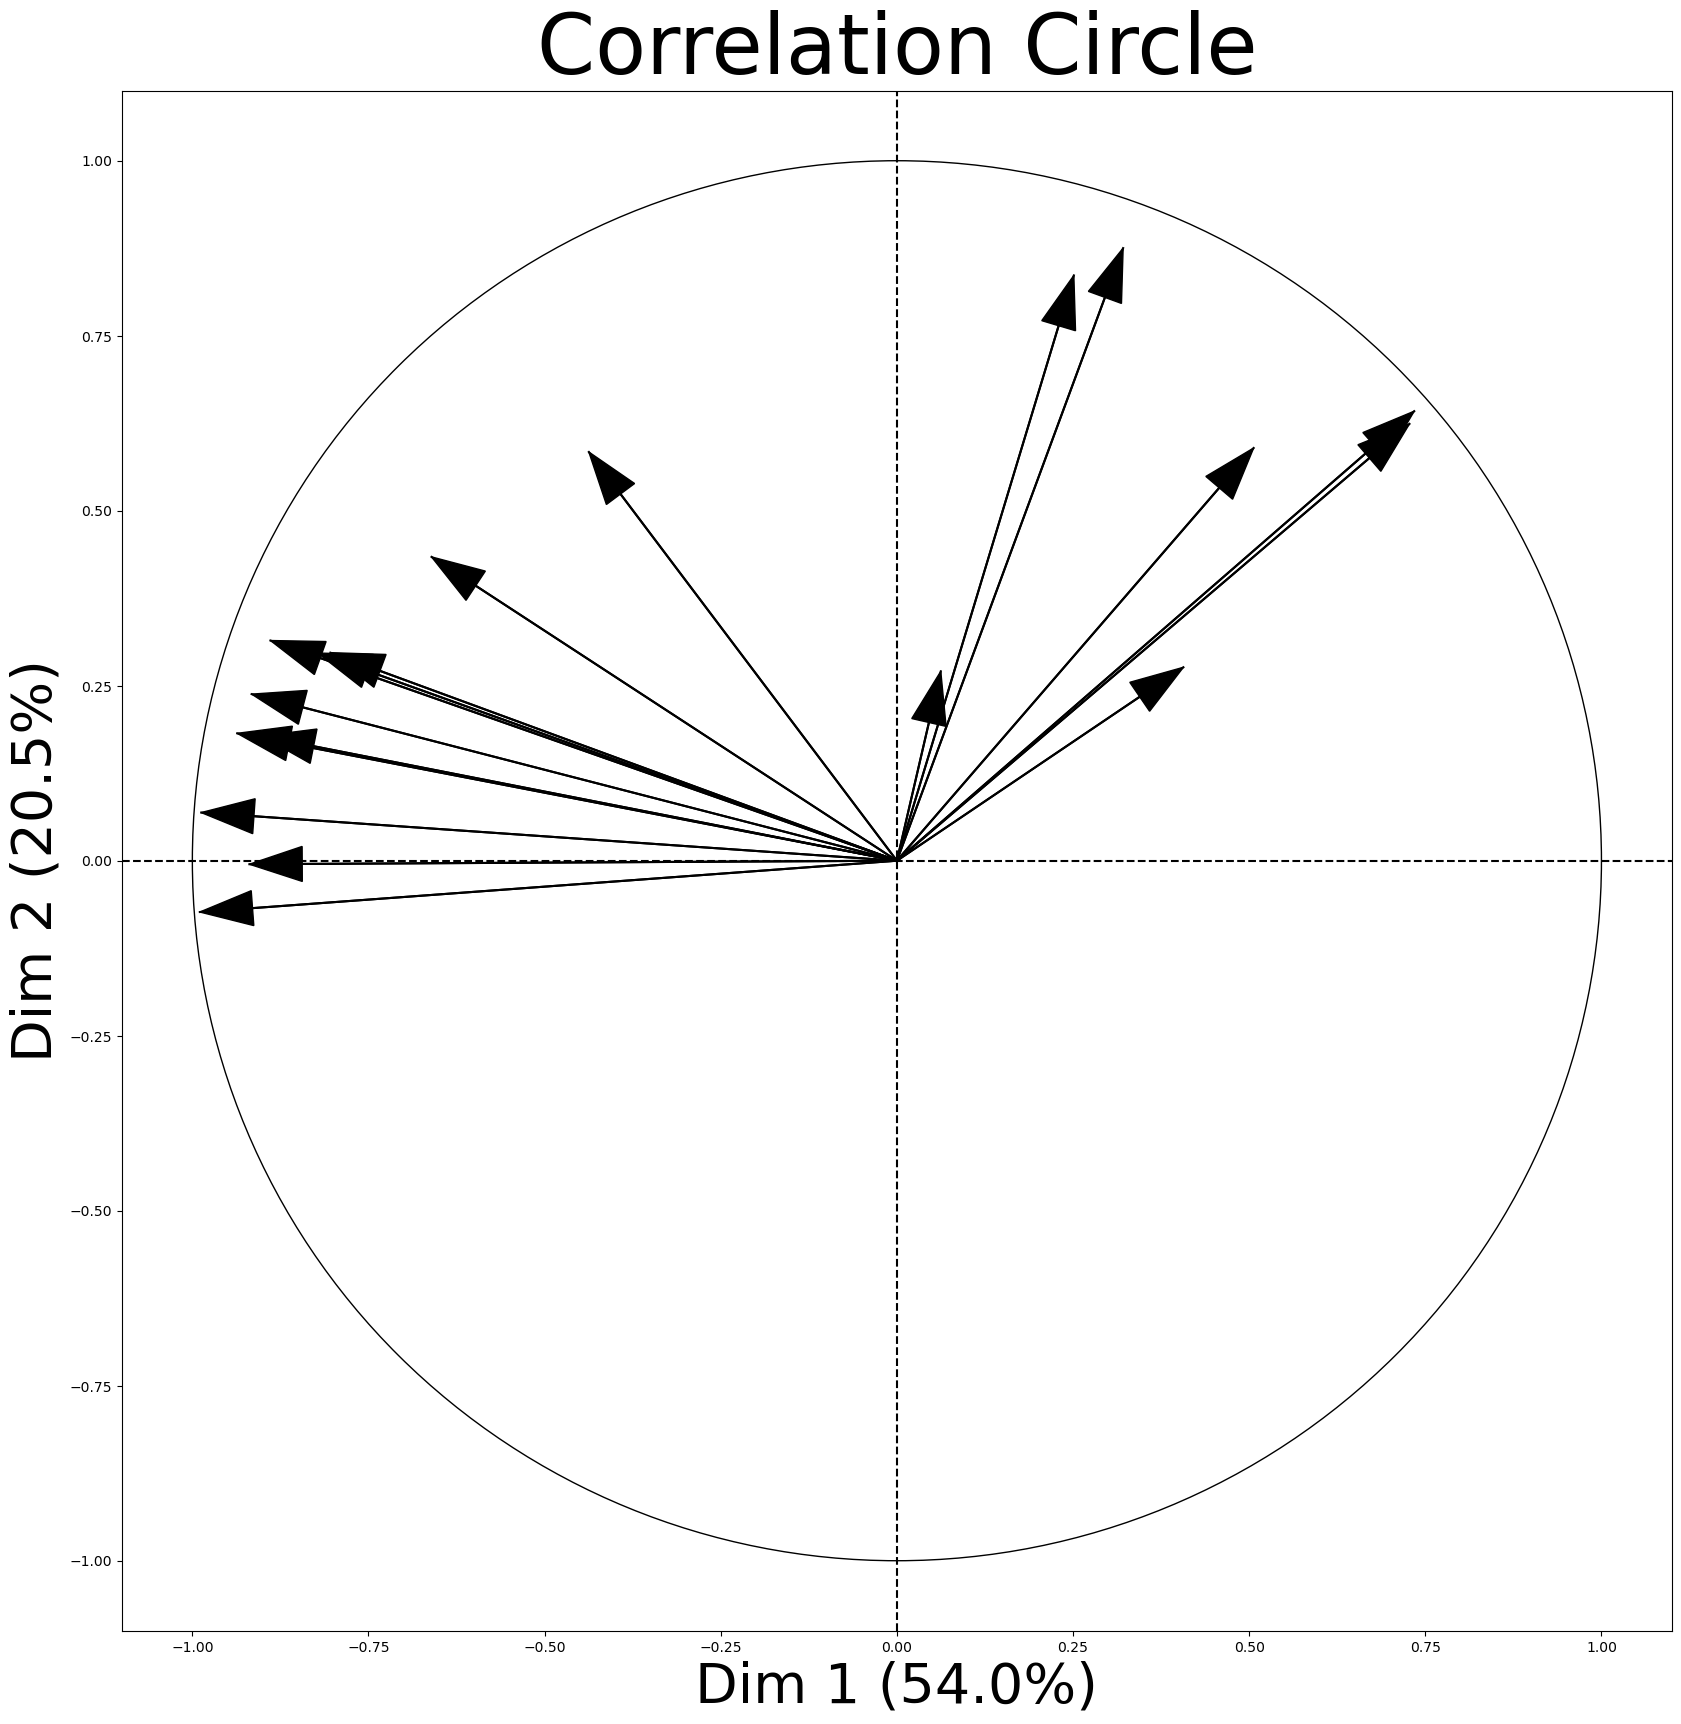

arrow < 0.8 ['Delay_ch2', 'Delay_ch8', 'Delay_ch11', 'Delay_ch12', 'Delay_ch13']


In [ ]:
#readpath = r'/Users/arzina/Library/CloudStorage/OneDrive-UniversityofCambridge/11B/4TH YR PROJECT/Delays_thirdof3peaks/all_fs2000.xlsx'
#readpath = r'/Users/arzina/Library/CloudStorage/OneDrive-UniversityofCambridge/11B/4TH YR PROJECT/Delays_thirdof3peaks/Delays_SearchWdw100/all_fs2000WIDTHS.xlsx'#SW100and350.xlsx'#all_fs2000P23.xlsx'#all_fs2000AMPS_SCALEDPERPATIENT.xlsx'#_scaledindividually.xlsx'
readpath = r'/Users/arzina/Library/CloudStorage/OneDrive-UniversityofCambridge/11B/4TH YR PROJECT/FeatureMatrices/fhigh20/V1/hfd_gradangle.xlsx'
#plotSpiderplotExpress2(datapath, 21)

#plotSpiderplotExpress2(datapath, )

#patients = [18,19,21,22,23,24,25,26,27,28,29] #18
stages = ['B1', 'B2', 'HEALHTY']
for p in stages:
    print('stage, B', p)
    figure, correlation_matrix = plotCorrCircle(readpath, p)

    cm_df = pd.DataFrame(correlation_matrix.T)

    cols_labels = []
    for ch in range(2,20):
        cols_labels += [f'Delay_ch{ch}']

    minimal_dist = []
    inbetweenangle = []
    #print(cm_df['Delay_ch2'])
    for label in cols_labels:
        #print(label)
        squared = cm_df[label][0]**2 + cm_df[label][1]**2
        if squared < 0.64:  # this is 0.6^2 etc
            minimal_dist.append(label)
        
        theta = np.arctan(np.abs(cm_df[label][1] / cm_df[label][0])) * 180 / np.pi
        #print('theta', theta)

        if theta > 40 and theta < 50:
            inbetweenangle.append(label)

    print('arrow < 0.8', minimal_dist)
    #print('40<angle<50', inbetweenangle)




In [ ]:
cm_df = pd.DataFrame(correlation_matrix.T)

cols_labels = []
for ch in range(2,20):
    cols_labels += [f'Delay_ch{ch}']

minimal_dist = []
inbetweenangle = []
#print(cm_df['Delay_ch2'])
for label in cols_labels:
    print(label)
    squared = cm_df[label][0]**2 + cm_df[label][1]**2
    if squared < 0.36:  # this is 0.6^2 etc
        minimal_dist.append(label)
    
    theta = np.arctan(np.abs(cm_df[label][1] / cm_df[label][0])) * 180 / np.pi
    #print('theta', theta)

    if theta > 40 and theta < 50:
        inbetweenangle.append(label)

print('arrow < 0.6', minimal_dist)
print('40<angle<50', inbetweenangle)



Delay_ch2
Delay_ch3
Delay_ch4
Delay_ch5
Delay_ch6
Delay_ch7
Delay_ch8
Delay_ch9
Delay_ch10
Delay_ch11
Delay_ch12
Delay_ch13
Delay_ch14
Delay_ch15
Delay_ch16
Delay_ch17
Delay_ch18
Delay_ch19
arrow < 0.6 ['Delay_ch4', 'Delay_ch5', 'Delay_ch9', 'Delay_ch11', 'Delay_ch16', 'Delay_ch17']
40<angle<50 []


/var/folders/xk/7pkq41bj7yd1lwnqdfl88v0r0000gn/T/ipykernel_1046/1124986604.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  squared = cm_df[label][0]**2 + cm_df[label][1]**2
/var/folders/xk/7pkq41bj7yd1lwnqdfl88v0r0000gn/T/ipykernel_1046/1124986604.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  theta = np.arctan(np.abs(cm_df[label][1] / cm_df[label][0])) * 180 / np.pi


#### Explained variance plot

[23.92988955 19.60964729 12.81632216  8.72567236  5.45508613  3.30256666
  2.43826729  2.01843718  1.77711137  1.53943953]


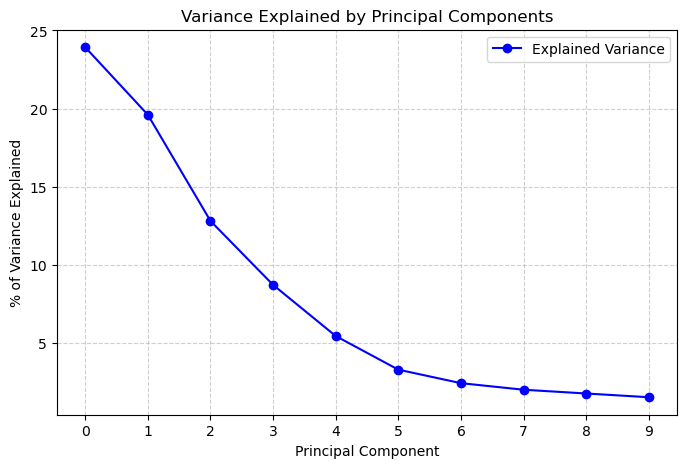

In [4]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
#readpath = r'/Users/arzina/Library/CloudStorage/OneDrive-UniversityofCambridge/11B/4TH YR PROJECT/Delays_thirdof3peaks/all_fs2000.xlsx'#_scaledindividually.xlsx'
#addon = 'all_fs2000SW100and350'
#readpath = r'/Users/arzina/Desktop/HFD.xlsx'#r'/Users/arzina/Library/CloudStorage/OneDrive-UniversityofCambridge/11B/4TH YR PROJECT/FeatureMatrices/widths_SCALEDPERPATIENT.xlsx'
""" readpath = r'/Users/arzina/Library/CloudStorage/OneDrive-UniversityofCambridge/11B/4TH YR PROJECT/FeatureMatrices/V1/hfd/hfd_GRADANGLE.xlsx'
df = pd.read_excel(io=readpath)
# checking shape
print('Original Dataframe shape :',df.shape)

X = df.drop('stage',axis=1).drop('patient',axis=1)

# Input features
#X = df[cancer['feature_names']]
print('Inputs Dataframe shape   :', X.shape)

# Standardization
X_mean = X.mean()
X_std = X.std()
Z = (X - X_mean) / X_std

 """
n_components = 10
pca = PCA(n_components)
pca.fit(Z) # Fit the model with Z
variance = pca.explained_variance_ratio_*100
print(variance)
x = np.arange(n_components)

plt.figure(figsize=(8, 5))  # Set figure size
plt.plot(x, variance, marker='o', linestyle='-', color='b', label="Explained Variance")
plt.xlabel("Principal Component")  # X-axis label
plt.ylabel("% of Variance Explained")  # Y-axis label
plt.title("Variance Explained by Principal Components")  # Title
plt.grid(True, linestyle='--', alpha=0.6)  # Add a light grid
plt.xticks(x)  # Ensure all components are labeled
plt.legend()  # Show legend
plt.show()  # Display plot


